In [35]:
# Importando Bibliotecas
import pandas as pd
from scipy.stats import zscore
from AnalysisUtils import *
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def encode_string_columns(df):
  for col in df.select_dtypes(include=['object', 'category']).columns:
    # Check if the column is binary with values "sim" and "nao"
    if df[col].isin(["sim", "nao"]).all():
      df[f"{col}_"] = df[col].map({"sim": 1, "nao": 0})
    else:
      df[f"{col}_"] = pd.factorize(df[col])[0]
  return df

# no need for an advanced techinice for replacing missing values as most missing values represent less than 1% of the data
def fill_missing_data(df):
  for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
      df[col] = df[col].fillna(df[col].mean())
    else:
      if df[col].notna().any():
        df[col] = df[col].fillna(df[col].mode()[0])
  return df

def detect_outliers(df):
  z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
  outliers = z_scores > 3  # Consider values with Z-score greater than 3 as outliers
  return outliers.sum()

def analyze_numerical_column(row):
  print_simple_metrics(row)
  boxplot_with_quartiles(row, yscale='linear')
  create_filtered_histograms(row, log=False, filters=None, color='blue', bins=100)

def calculate_group_metric(df, category_columns, numerical_columns, metric='median'):
  result_list = []
  
  for i in range(len(category_columns)):
    for value in df[category_columns[i]].unique():
      group_df = df[df[category_columns[i]] == value]
      
      if metric == 'median':
        group_metric = group_df[numerical_columns].median()
      else:
        group_metric = group_df[numerical_columns].mean()
      
      group_metric['category'] = f"{category_columns[i]}: {value}"
      result_list.append(group_metric)

  result_df = pd.DataFrame(result_list)
  
  return result_df

def plot_sorted_group_metric(result_df, numerical_columns, metric='median'):
  for col in numerical_columns:
    # Sort the result DataFrame by the median of the current column
    sorted_df = result_df.set_index('category').sort_values(by=col).reset_index()

    # Normalize the median values for coloring
    norm = plt.Normalize(sorted_df[col].min(), sorted_df[col].max())
    cmap = plt.cm.viridis  # You can change this to another colormap, e.g., 'plasma', 'inferno', etc.

    # Create a new figure for each numerical column
    plt.figure(figsize=(10, 6))

    # Create the gradient bars by mapping the median values to the color map
    bars = plt.bar(sorted_df['category'], sorted_df[col], color=cmap(norm(sorted_df[col])), width=0.6)

    # Set labels and title for the plot
    plt.xlabel('Category')
    plt.ylabel(f'{metric} of {col}')
    plt.title(f'Sorted {metric}s of {col} by Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add a color bar to indicate the gradient scale
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca())
    cbar.set_label(f'Median Value of {col}')

    # Show the plot
    plt.show()

def plot_all_category_columns(df, category_columns, color='skyblue', top=10):
  num_columns = len(category_columns)
  rows = (num_columns // 3) + (num_columns % 3 > 0)

  fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
  axes = axes.flatten()

  for idx, column in enumerate(category_columns):
    ax = axes[idx]

    # Get the value counts for the encoded column
    result_df = df[column].value_counts().reset_index()
    result_df.columns = [column, 'Count']
    result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100

    # Keep only top N values if specified
    result_df = result_df.head(top)

    # Plot the bar chart
    result_df.plot(kind='bar', x=column, y='Count', color=color, ax=ax, legend=False)

    ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
    ax.set_xlabel('Values', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
      ax.text(i, count + 0.5, f'{count} / {pct:.1f}%', ha='center', va='bottom')

  # Remove any empty axes
  for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

  plt.subplots_adjust(hspace=0.5, wspace=0.3)
  plt.tight_layout()
  plt.show()

def scale_numerical_data(df, columns):
  scaler = StandardScaler()
  df[columns] = scaler.fit_transform(df[columns])
  return df

def scale_and_prepare_data(df, categorical_columns, numerical_columns):
  # One-hot encode categorical columns
  df_dummies = pd.get_dummies(df[categorical_columns], drop_first=False)

  # Initialize StandardScaler
  scaler = StandardScaler()

  # Scale the specified numerical columns
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

  # Scale the one-hot encoded categorical columns (df_dummies)
  df_dummies_scaled = scaler.fit_transform(df_dummies)

  # Convert the scaled dummies back to a DataFrame and assign correct column names manually
  df_dummies_scaled = pd.DataFrame(df_dummies_scaled, columns=df_dummies.columns, index=df.index)

  # Concatenate the scaled numerical columns with the scaled one-hot encoded columns
  df = pd.concat([df[numerical_columns], df_dummies_scaled], axis=1)

  return df

def add_health_columns(df):
    # Calcular IMC
    df['IMC'] = df['peso'] / (df['altura'] ** 2)

    # Calcular IMG
    def calculate_img(row):
        if row['sexo'] == 'M':
            return 1.2 * row['IMC'] + 0.23 * row['idade'] - 16.2
        elif row['sexo'] == 'F':
            return 1.2 * row['IMC'] + 0.23 * row['idade'] - 5.4
        else:
            return None  # Caso o sexo não seja especificado

    df['IMG'] = df.apply(calculate_img, axis=1)

    # Classificar IMG
    def classify_img(img):
        if img < 6:
            return 'Muito baixo'
        elif img < 14:
            return 'Baixo'
        elif img < 18:
            return 'Adequado'
        elif img < 25:
            return 'Acima do ideal'
        else:
            return 'Muito alto'

    df['Class_IMG'] = df['IMG'].apply(classify_img)

    return df



In [28]:
numerical_columns = ['idade', 'idade_int', 'altura', 'peso', 'consome_vegetais', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua', 'consumo_diario_agua_int', 'frequencia_atividade_fisica', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos', 'tempo_usando_eletronicos_int', 'IMG', 'IMC']

category_columns = ['sexo', 'historico_obesidade_familia', 'consome_comida_calorica', 'come_entre_refeicoes', 'fuma', 'consumo_alcool', 'tipo_transporte', 'Class_IMG']

category_columns_ = ['sexo_', 'historico_obesidade_familia_', 'consome_comida_calorica_', 'come_entre_refeicoes_', 'fuma_', 'consumo_alcool_', 'tipo_transporte_', 'Class_IMG']

In [29]:
# Importando dados
df = pd.read_csv('data/trabalho2_dados_4.csv')
df = fill_missing_data(df) # substituindo valores faltantes numéricos pela media e categóricos pela moda
df['idade_int'] = np.floor(df['idade'])
df['n_refeicoes_int'] = df['n_refeicoes'].round()
df['consome_vegetais_int'] = df['consome_vegetais'].round()
df['consumo_diario_agua_int'] = df['consumo_diario_agua'].round()
df['frequencia_atividade_fisica_int'] = df['frequencia_atividade_fisica'].round()
df['tempo_usando_eletronicos_int'] = df['tempo_usando_eletronicos'].round()

df = add_health_columns(df)

df = encode_string_columns(df) # encodando colunas de string
df = df.drop_duplicates(df, keep='first') # remoção de ~250 entradas duplicadas (substituição de valores faltantes e transformação direta em int nao criaram novas duplicados apenas 1 para o caso de substituição
df

,sexo,idade,altura,peso,historico_obesidade_familia,consome_comida_calorica,consome_vegetais,n_refeicoes,come_entre_refeicoes,fuma,...,IMG,Class_IMG,sexo_,historico_obesidade_familia_,consome_comida_calorica_,come_entre_refeicoes_,fuma_,consumo_alcool_,tipo_transporte_,Class_IMG_
0,M,31.264628,1.803129,91.052215,sim,sim,2.409608,3.000000,as vezes,nao,...,24.596968,Acima do ideal,0,1,1,0,0,0,0,0
1,M,21.000000,1.620000,70.000000,nao,sim,2.000000,1.000000,nao,nao,...,20.637316,Acima do ideal,0,0,1,1,0,0,0,0
2,F,18.019572,1.701378,50.088468,nao,sim,1.601236,3.433908,as vezes,nao,...,19.508805,Acima do ideal,1,0,1,0,0,0,0,0
3,F,25.918524,1.621231,104.986792,sim,sim,3.000000,2.676320,as vezes,nao,...,48.493323,Muito alto,1,1,1,0,0,0,0,1
4,F,33.000000,1.590000,60.000000,nao,sim,3.000000,1.000000,frequentemente,nao,...,30.669886,Muito alto,1,0,1,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,F,26.000000,1.640745,110.919646,sim,sim,2.409608,3.000000,as vezes,nao,...,50.023311,Muito alto,1,1,1,0,0,0,0,1
1092,M,26.000000,1.700000,70.000000,sim,nao,3.000000,1.000000,frequentemente,nao,...,18.845744,Acima do ideal,0,1,0,2,0,2,0,0
1094,F,16.000000,1.570000,49.000000,nao,sim,2.000000,4.000000,sempre,nao,...,22.134923,Acima do ideal,1,0,1,3,0,0,0,0
1097,M,31.346845,1.823545,126.460936,sim,sim,2.938801,3.000000,as vezes,sim,...,36.645469,Muito alto,0,1,1,0,1,0,0,1


In [30]:
detect_outliers(df) 
# Não foram detectados outliers relevantes nas métricas numéricas
# a unica metrica com outliers usando z_score foi a de idade, mas essa distribuição não é normal, e foram apenas 7 encontrados
# nas métricas categóricas, isso removeria certas do categorias do dataset, portanto, não é necessário remover outliers neste dataset

idade                               7
altura                              0
peso                                0
consome_vegetais                    0
n_refeicoes                         0
consumo_diario_agua                 0
frequencia_atividade_fisica         0
tempo_usando_eletronicos            0
idade_int                           7
n_refeicoes_int                     0
consome_vegetais_int                0
consumo_diario_agua_int             0
frequencia_atividade_fisica_int     0
tempo_usando_eletronicos_int        0
IMC                                 0
IMG                                 0
sexo_                               0
historico_obesidade_familia_        0
consome_comida_calorica_            0
come_entre_refeicoes_              18
fuma_                              19
consumo_alcool_                    26
tipo_transporte_                   27
Class_IMG_                          1
dtype: int64

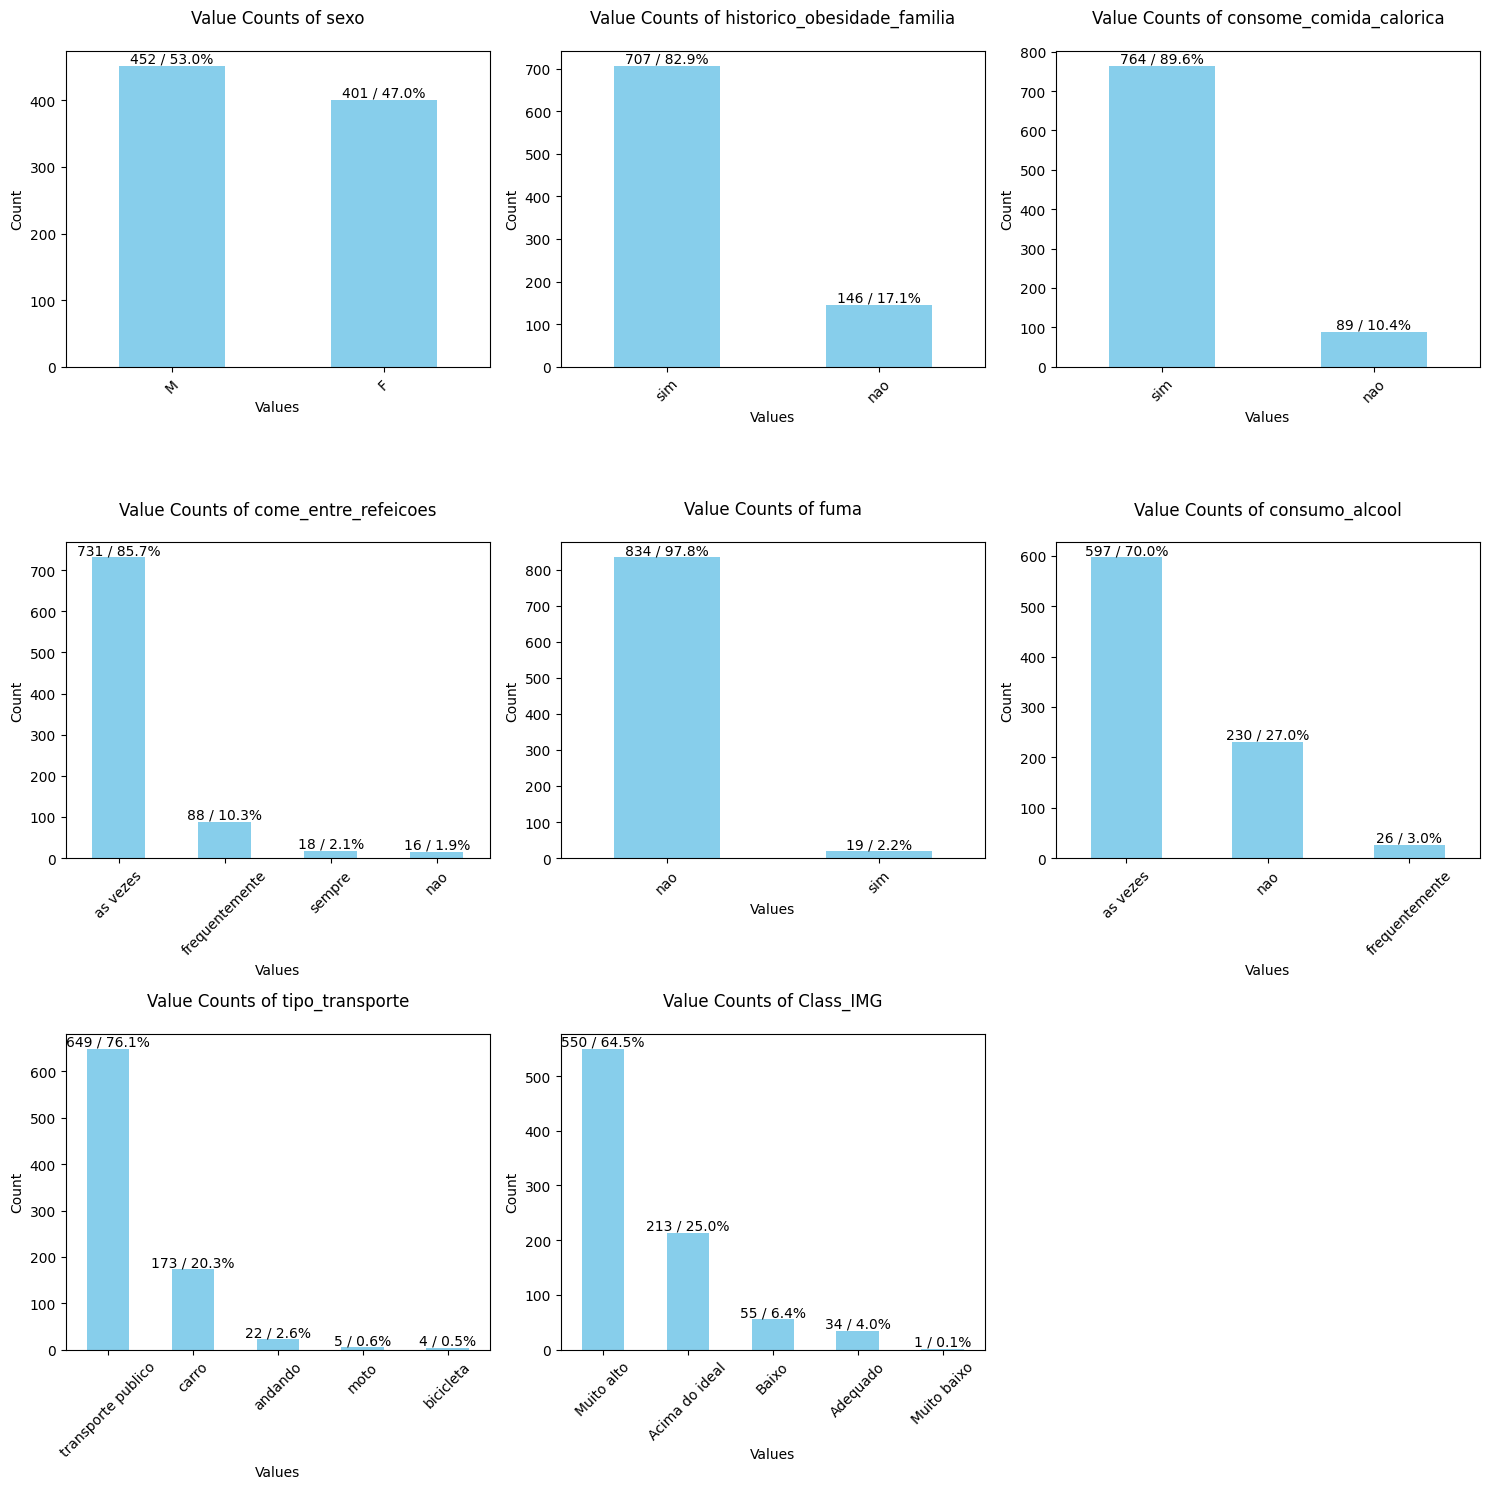

In [31]:
plot_all_category_columns(df, category_columns, color='skyblue', top=10)


--------------------------------------

métricas gerais para idade
média: 24.3018142143586
mediana: 22.989846
desvio padrão: 6.123596658995256
kurtosis: 2.362917224672291
skewness: 1.4397624400338975

--------------------------------------



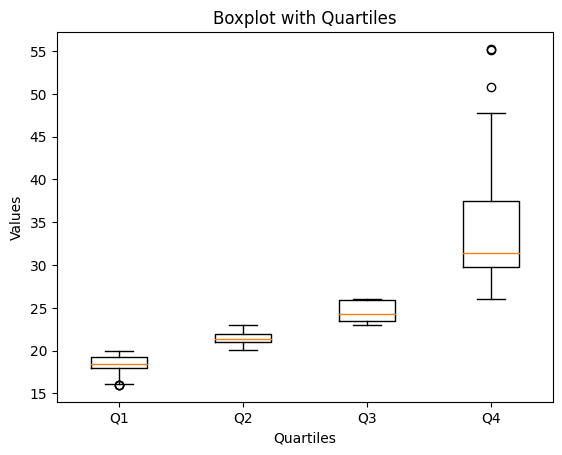


--------------------------------------

Histogramas para a coluna idade com log: False e bins: 100
idade <= 55.24625


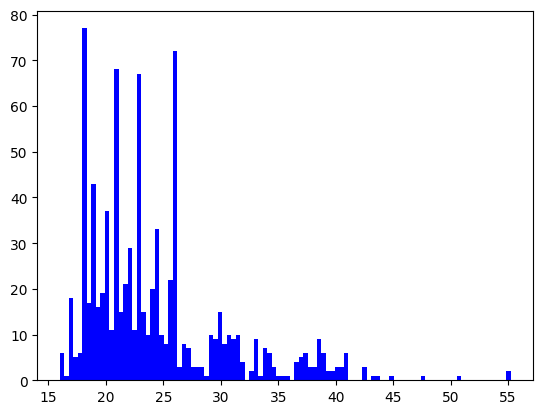


--------------------------------------

idade <= 26.0


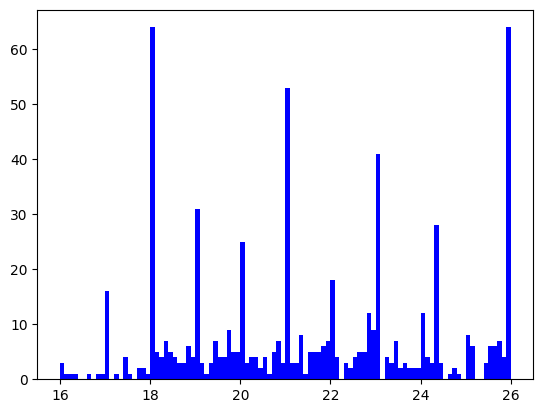


--------------------------------------

idade <= 22.989846


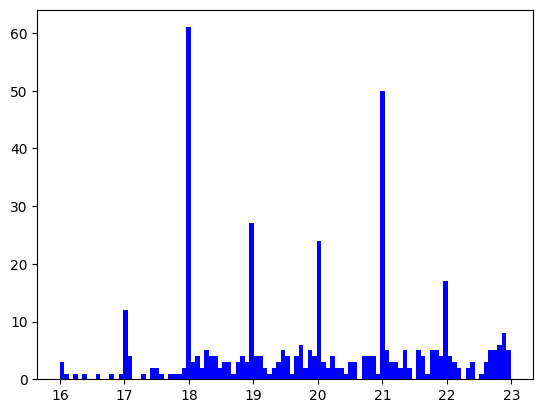


--------------------------------------

idade <= 20.0


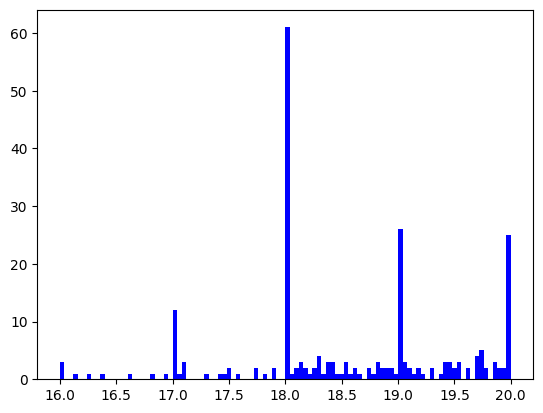


--------------------------------------


--------------------------------------

métricas gerais para idade_int
média: 23.966002344665885
mediana: 22.0
desvio padrão: 6.071562095292266
kurtosis: 2.4542379638166096
skewness: 1.4623188874825837

--------------------------------------



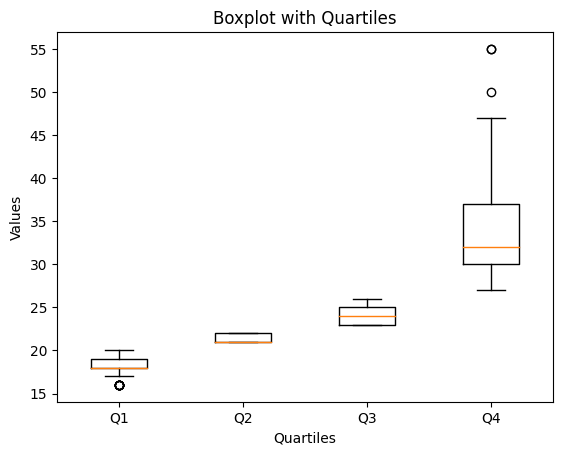


--------------------------------------

Histogramas para a coluna idade_int com log: False e bins: 100
idade_int <= 55.0


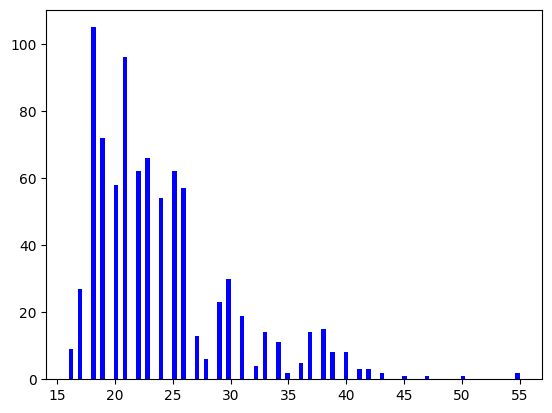


--------------------------------------

idade_int <= 26.0


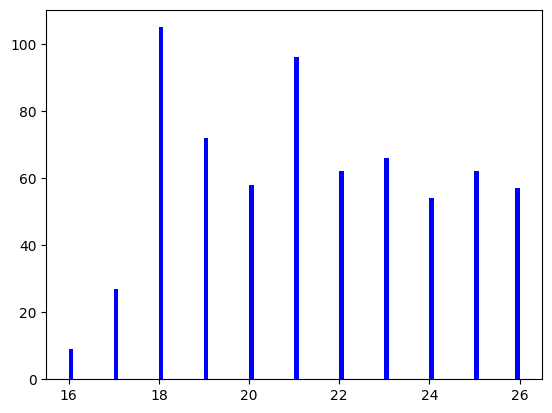


--------------------------------------

idade_int <= 22.0


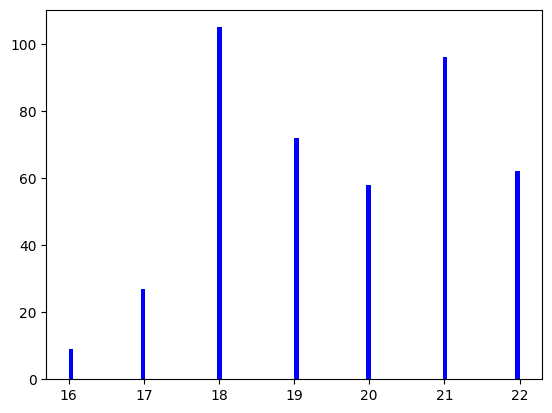


--------------------------------------

idade_int <= 20.0


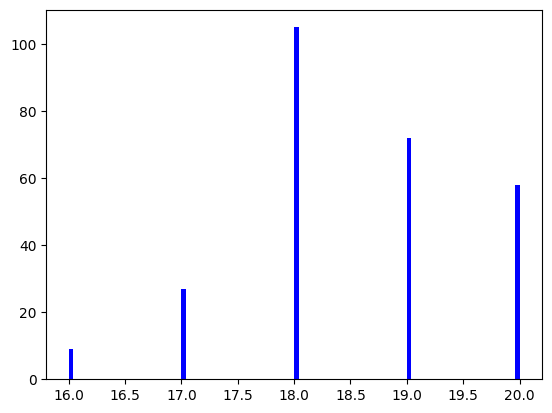


--------------------------------------


--------------------------------------

métricas gerais para altura
média: 1.7047595808543716
mediana: 1.7037289720410065
desvio padrão: 0.09375168998729999
kurtosis: -0.4233132378649058
skewness: -0.07871629643156604

--------------------------------------



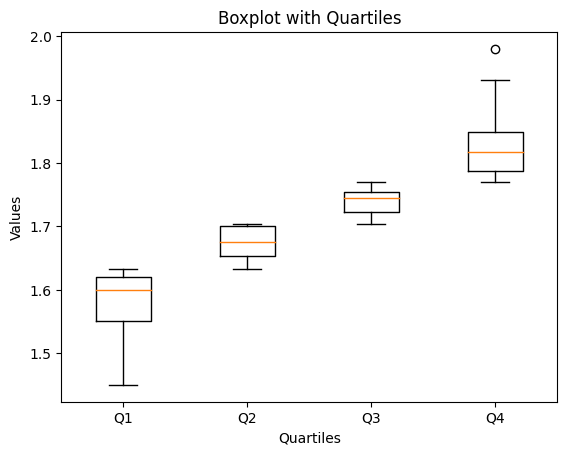


--------------------------------------

Histogramas para a coluna altura com log: False e bins: 100
altura <= 1.98


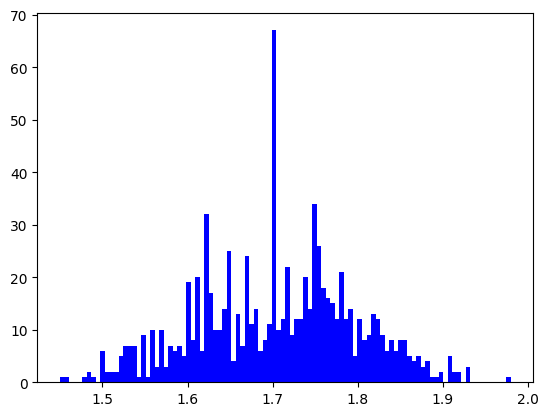


--------------------------------------

altura <= 1.769499


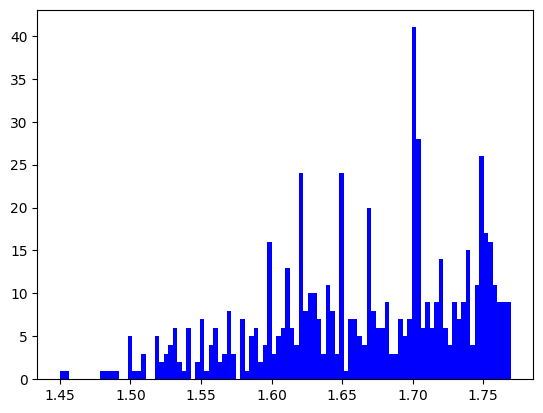


--------------------------------------

altura <= 1.7037289720410065


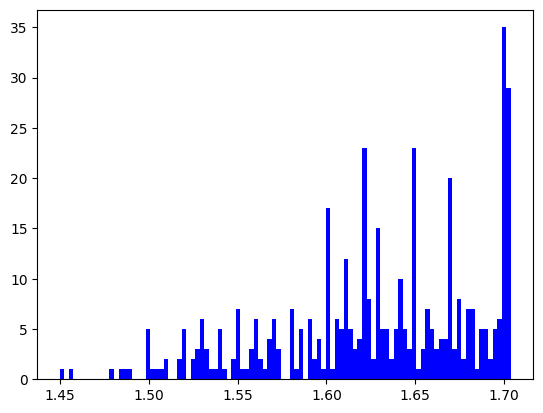


--------------------------------------

altura <= 1.633316


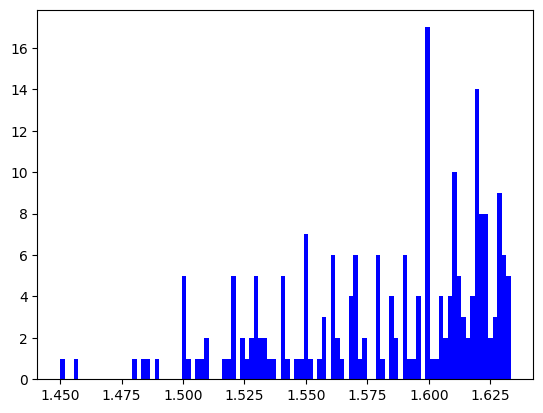


--------------------------------------


--------------------------------------

métricas gerais para peso
média: 88.2288571999991
mediana: 86.413388
desvio padrão: 25.84315976518909
kurtosis: -0.7508422089430291
skewness: 0.13269118456494242

--------------------------------------



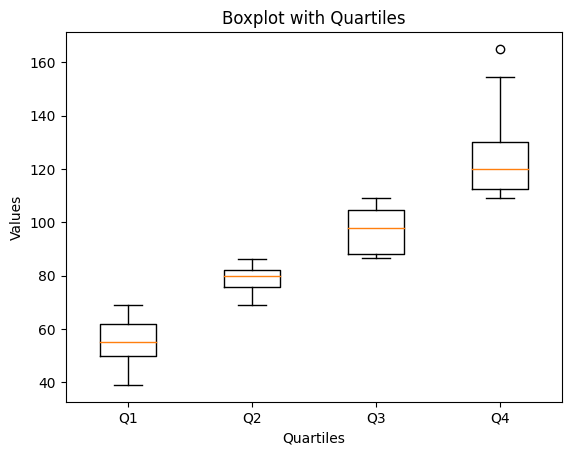


--------------------------------------

Histogramas para a coluna peso com log: False e bins: 100
peso <= 165.057269


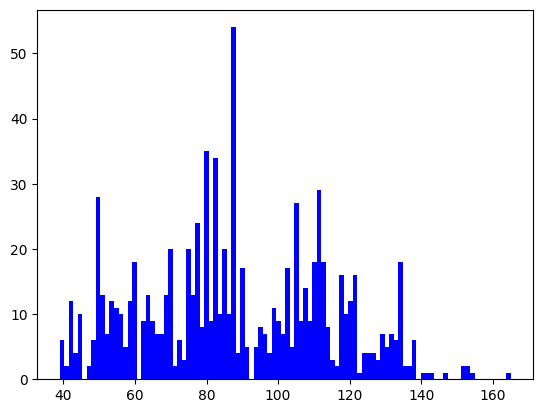


--------------------------------------

peso <= 109.0


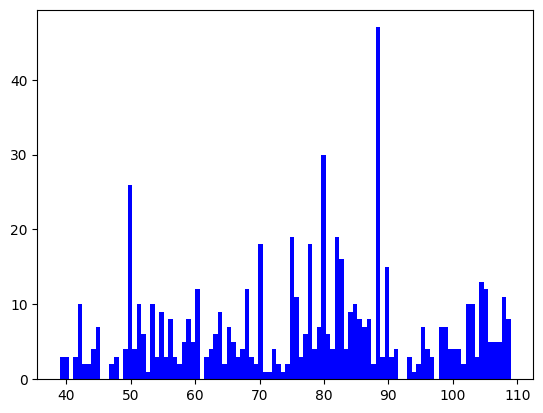


--------------------------------------

peso <= 86.413388


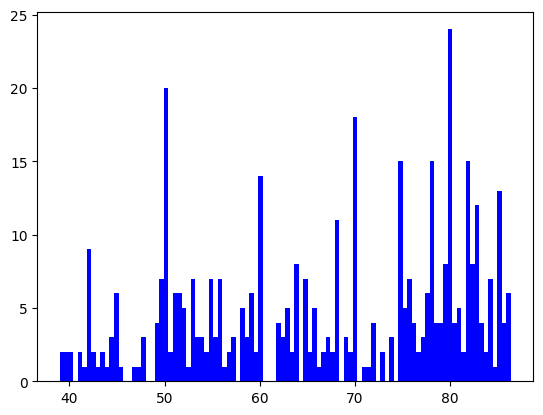


--------------------------------------

peso <= 68.908136


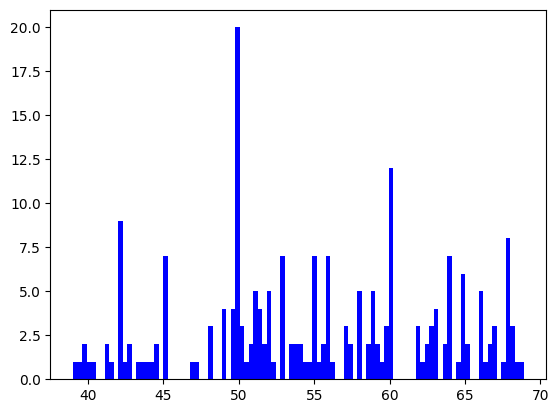


--------------------------------------


--------------------------------------

métricas gerais para consome_vegetais
média: 2.419073860672568
mediana: 2.4096084051233397
desvio padrão: 0.5219612506512726
kurtosis: -0.6101504583291613
skewness: -0.3976841570945984

--------------------------------------



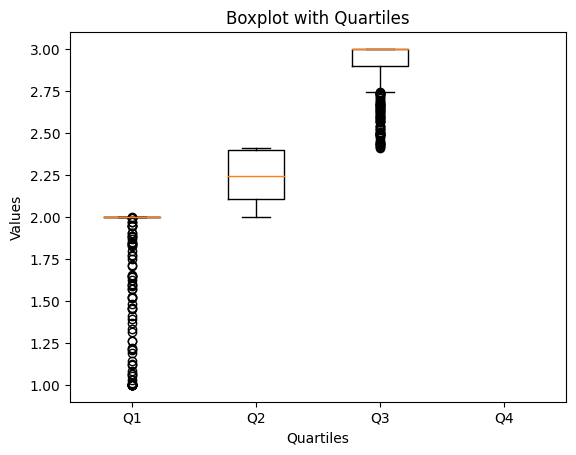


--------------------------------------

Histogramas para a coluna consome_vegetais com log: False e bins: 100
consome_vegetais <= 3.0


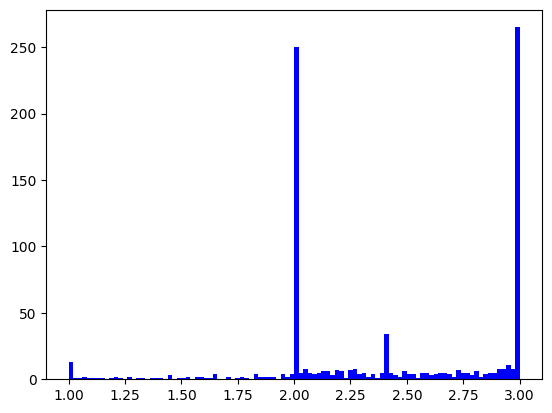


--------------------------------------

consome_vegetais <= 3.0


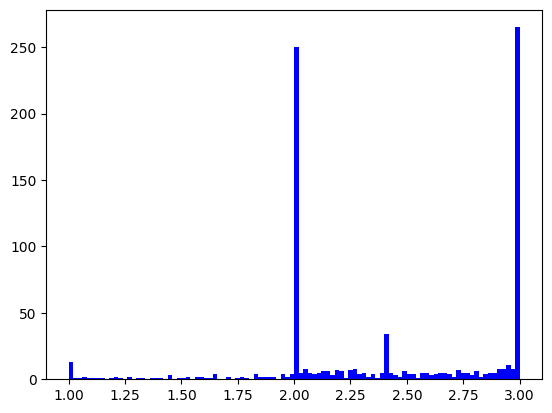


--------------------------------------

consome_vegetais <= 2.4096084051233397


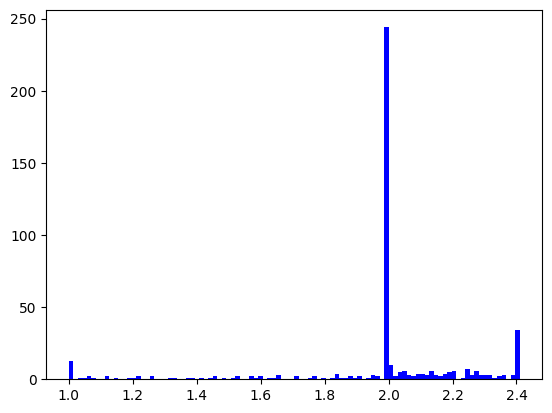


--------------------------------------

consome_vegetais <= 2.0


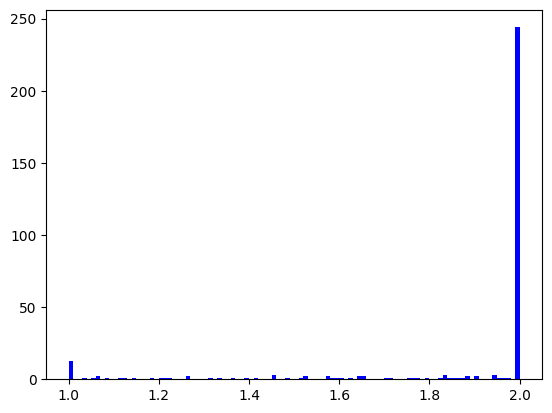


--------------------------------------


--------------------------------------

métricas gerais para consome_vegetais_int
média: 2.4079718640093786
mediana: 2.0
desvio padrão: 0.5712454387740116
kurtosis: -0.7858647850154257
skewness: -0.31627459181566836

--------------------------------------



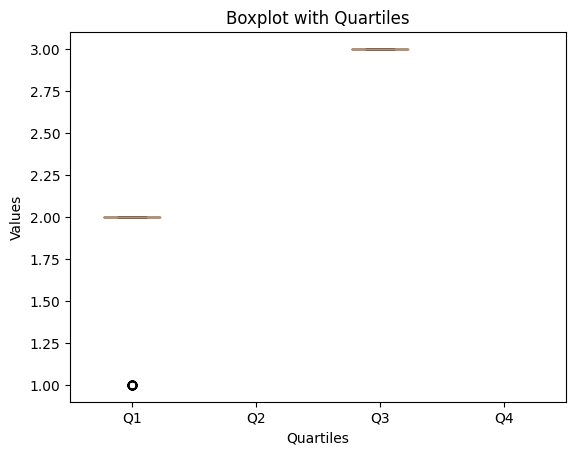


--------------------------------------

Histogramas para a coluna consome_vegetais_int com log: False e bins: 100
consome_vegetais_int <= 3.0


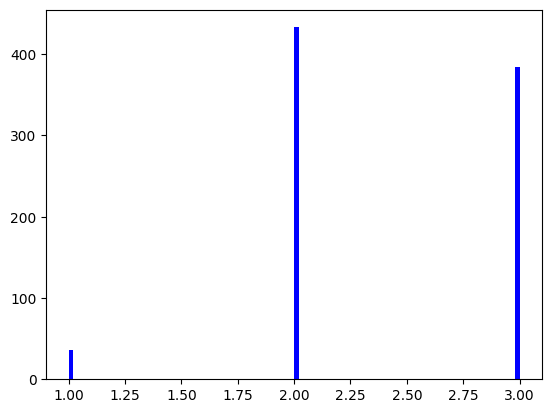


--------------------------------------

consome_vegetais_int <= 3.0


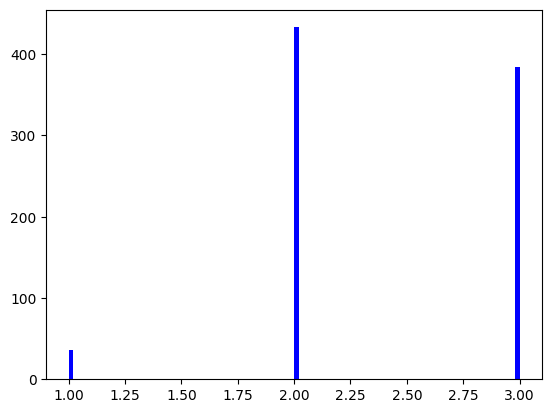


--------------------------------------

consome_vegetais_int <= 2.0


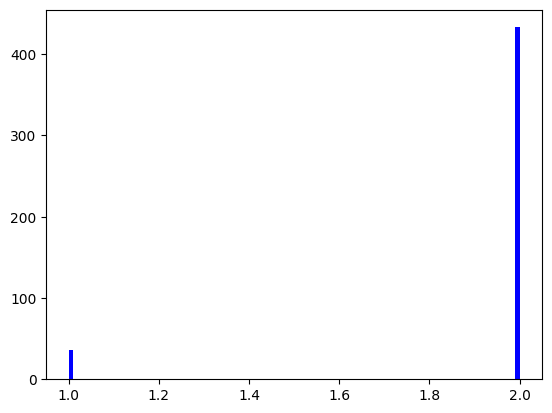


--------------------------------------

consome_vegetais_int <= 2.0


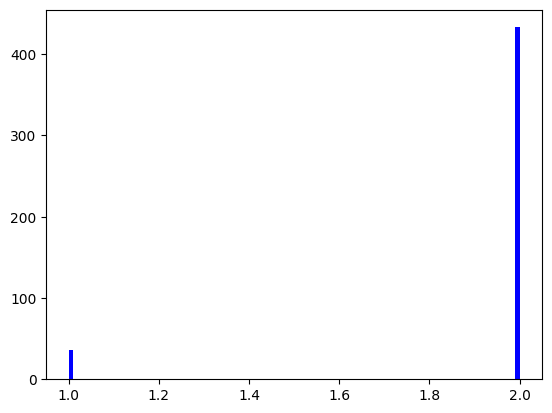


--------------------------------------


--------------------------------------

métricas gerais para n_refeicoes_int
média: 2.6998827667057443
mediana: 3.0
desvio padrão: 0.779106557855692
kurtosis: 0.6771478771781068
skewness: -1.1803175261755163

--------------------------------------



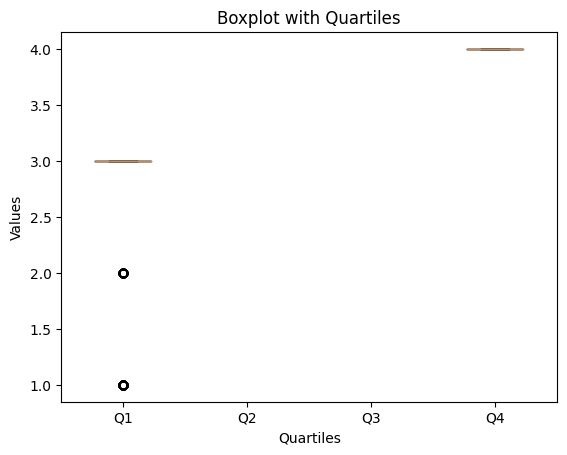


--------------------------------------

Histogramas para a coluna n_refeicoes_int com log: False e bins: 100
n_refeicoes_int <= 4.0


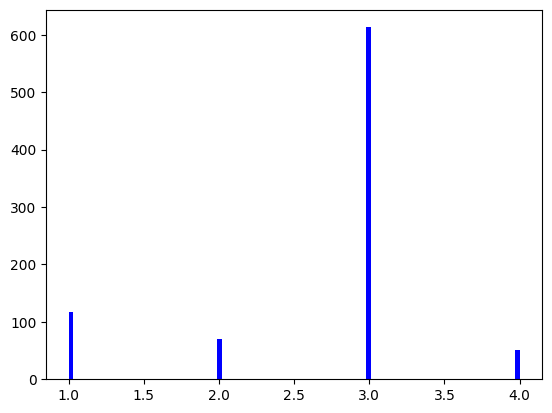


--------------------------------------

n_refeicoes_int <= 3.0


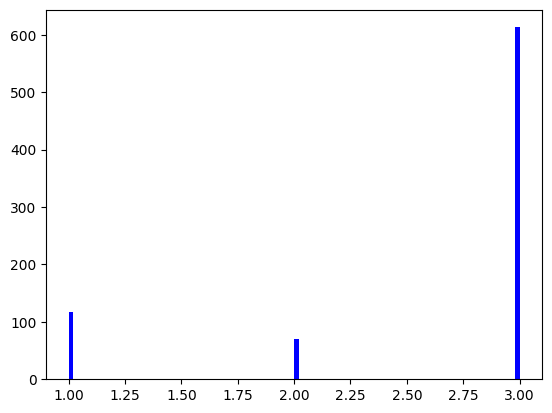


--------------------------------------

n_refeicoes_int <= 3.0


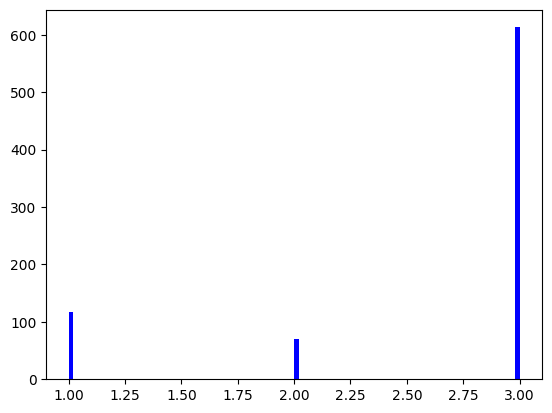


--------------------------------------

n_refeicoes_int <= 3.0


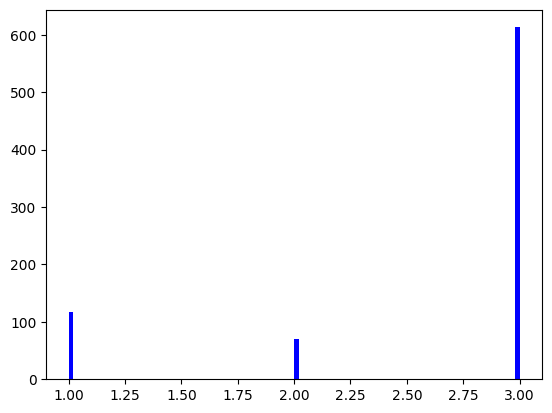


--------------------------------------


--------------------------------------

métricas gerais para consumo_diario_agua
média: 2.0011132187371414
mediana: 2.0
desvio padrão: 0.609540295939643
kurtosis: -0.8586759607547902
skewness: -0.11608291296719699

--------------------------------------



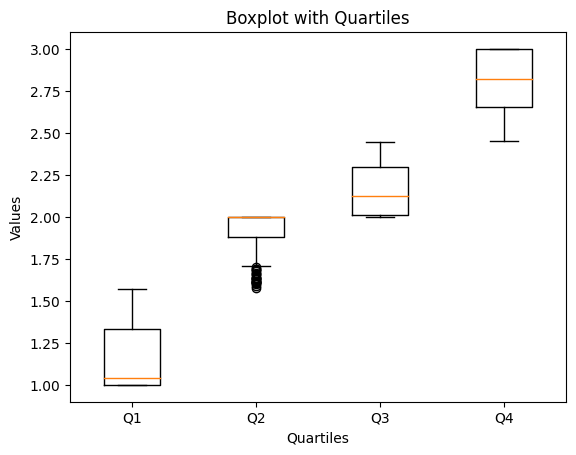


--------------------------------------

Histogramas para a coluna consumo_diario_agua com log: False e bins: 100
consumo_diario_agua <= 3.0


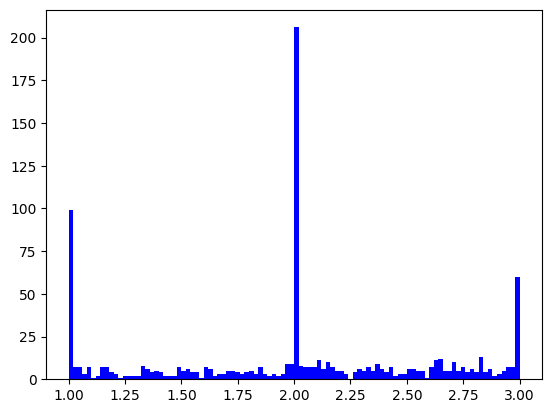


--------------------------------------

consumo_diario_agua <= 2.447306


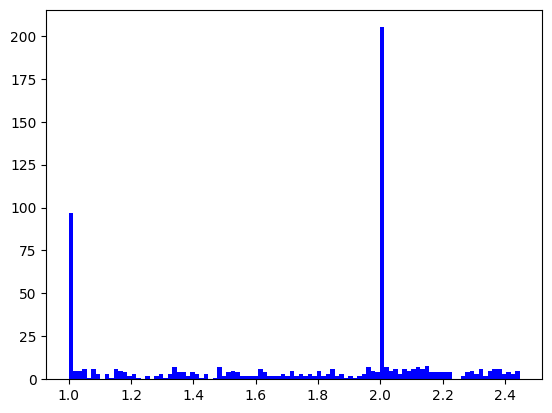


--------------------------------------

consumo_diario_agua <= 2.0


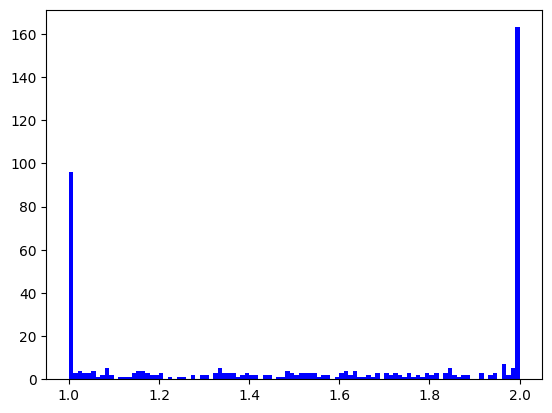


--------------------------------------

consumo_diario_agua <= 1.570188


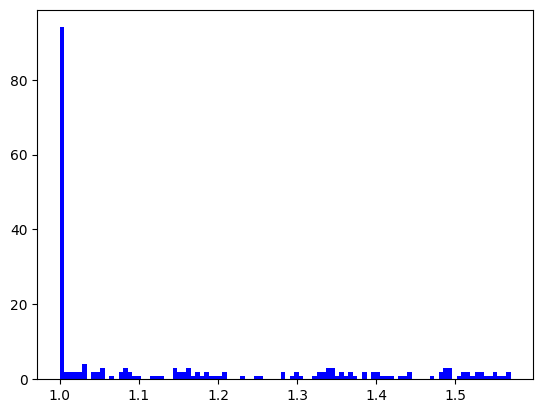


--------------------------------------


--------------------------------------

métricas gerais para consumo_diario_agua_int
média: 2.011723329425557
mediana: 2.0
desvio padrão: 0.6867993798426745
kurtosis: -0.8775974322043578
skewness: -0.01499210293865711

--------------------------------------



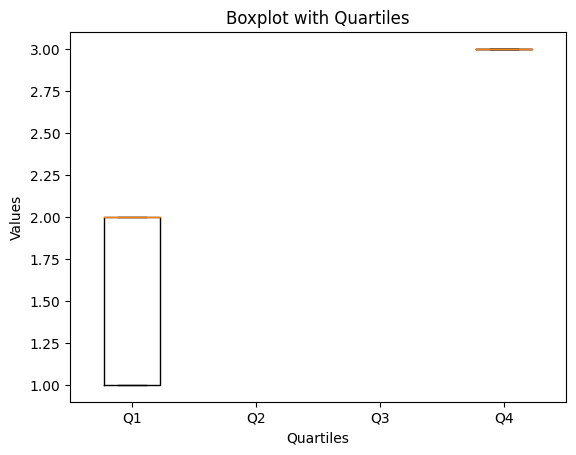


--------------------------------------

Histogramas para a coluna consumo_diario_agua_int com log: False e bins: 100
consumo_diario_agua_int <= 3.0


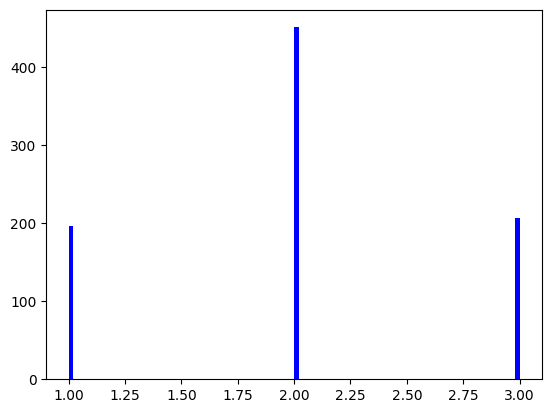


--------------------------------------

consumo_diario_agua_int <= 2.0


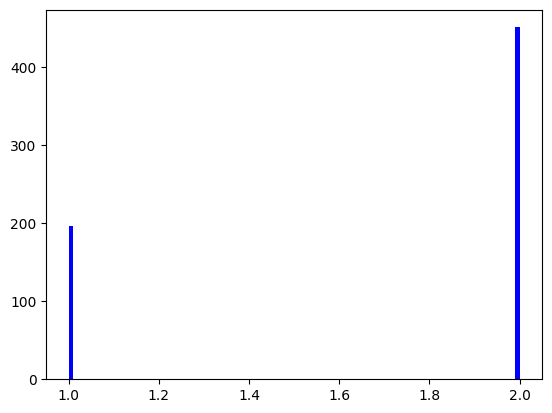


--------------------------------------

consumo_diario_agua_int <= 2.0


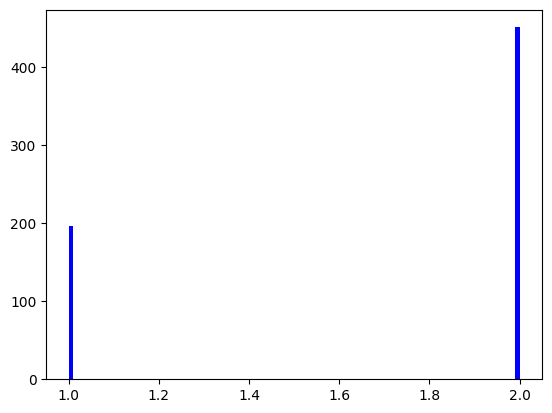


--------------------------------------

consumo_diario_agua_int <= 2.0


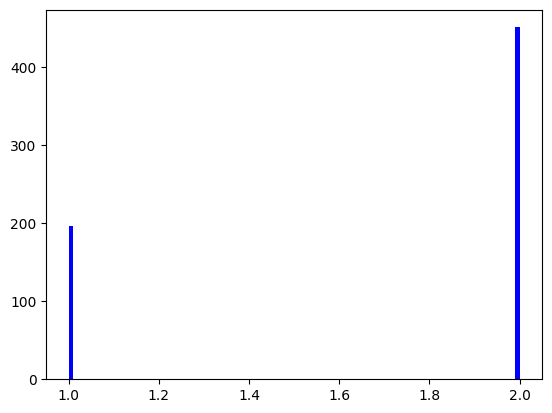


--------------------------------------


--------------------------------------

métricas gerais para frequencia_atividade_fisica
média: 0.9857324268955581
mediana: 0.9830633916745505
desvio padrão: 0.8381505706844988
kurtosis: -0.4316230473658713
skewness: 0.5707496324628661

--------------------------------------



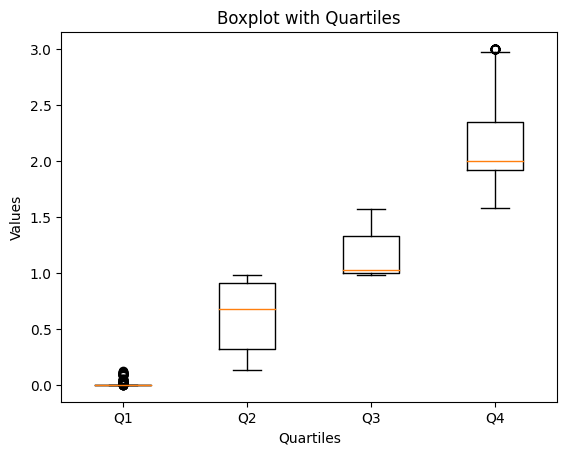


--------------------------------------

Histogramas para a coluna frequencia_atividade_fisica com log: False e bins: 100
frequencia_atividade_fisica <= 3.0


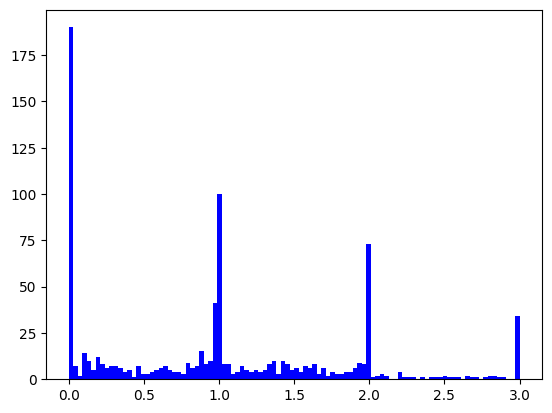


--------------------------------------

frequencia_atividade_fisica <= 1.571865


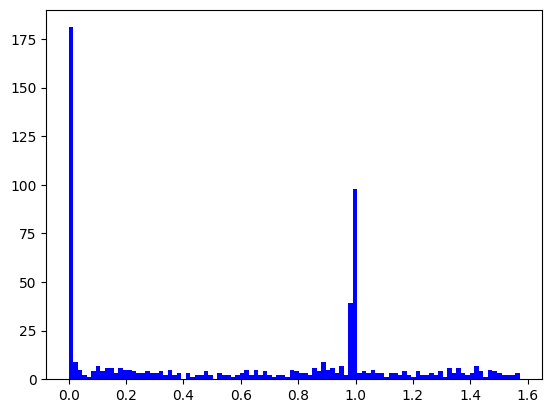


--------------------------------------

frequencia_atividade_fisica <= 0.9830633916745505


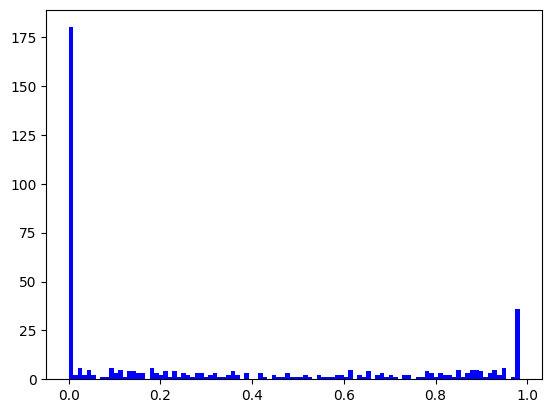


--------------------------------------

frequencia_atividade_fisica <= 0.127425


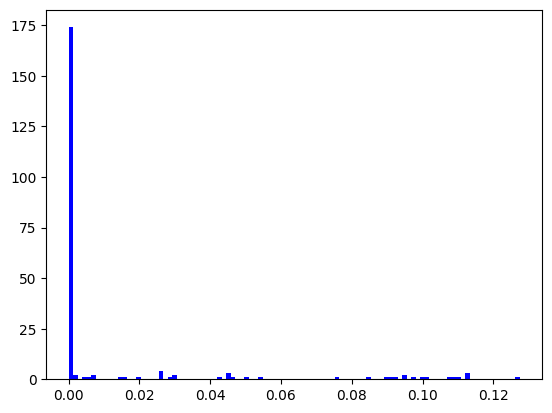


--------------------------------------


--------------------------------------

métricas gerais para frequencia_atividade_fisica_int
média: 0.977725674091442
mediana: 1.0
desvio padrão: 0.8831872417555022
kurtosis: -0.5288878804270989
skewness: 0.5445236279006023

--------------------------------------



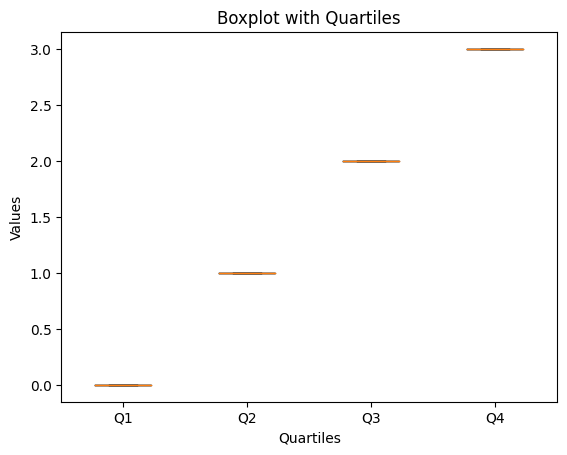


--------------------------------------

Histogramas para a coluna frequencia_atividade_fisica_int com log: False e bins: 100
frequencia_atividade_fisica_int <= 3.0


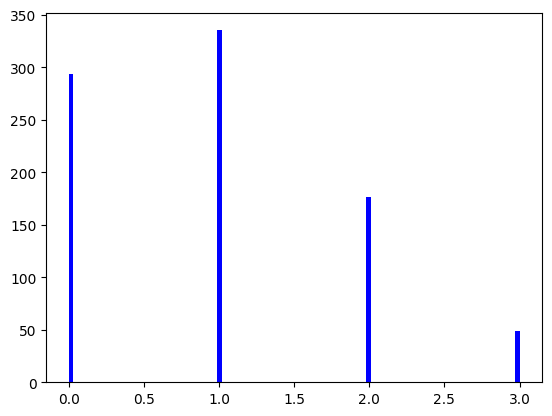


--------------------------------------

frequencia_atividade_fisica_int <= 2.0


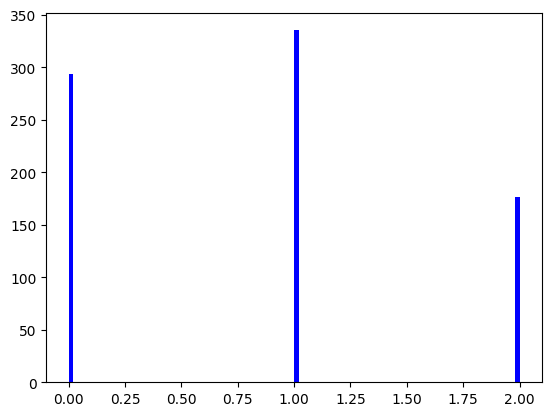


--------------------------------------

frequencia_atividade_fisica_int <= 1.0


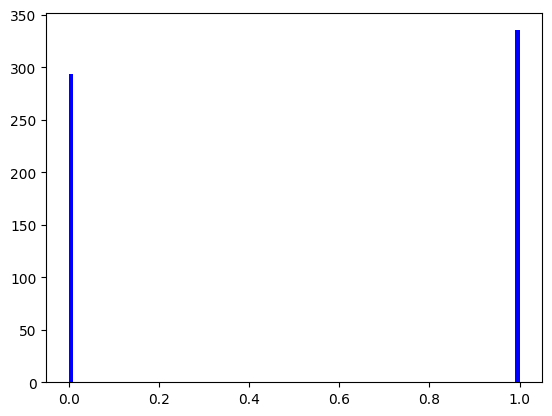


--------------------------------------

frequencia_atividade_fisica_int <= 0.0


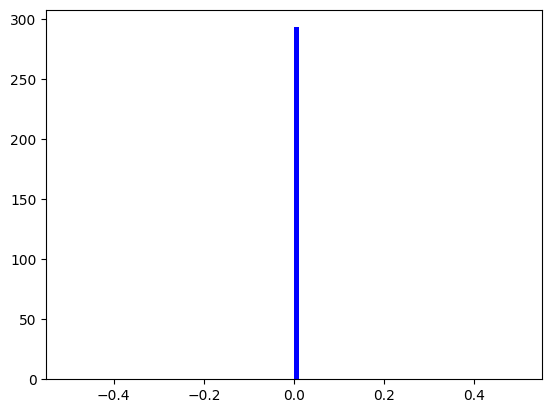


--------------------------------------


--------------------------------------

métricas gerais para tempo_usando_eletronicos
média: 0.6789711187584226
mediana: 0.6674500542056074
desvio padrão: 0.6137408710562771
kurtosis: -0.5872416667984619
skewness: 0.5858381399901182

--------------------------------------



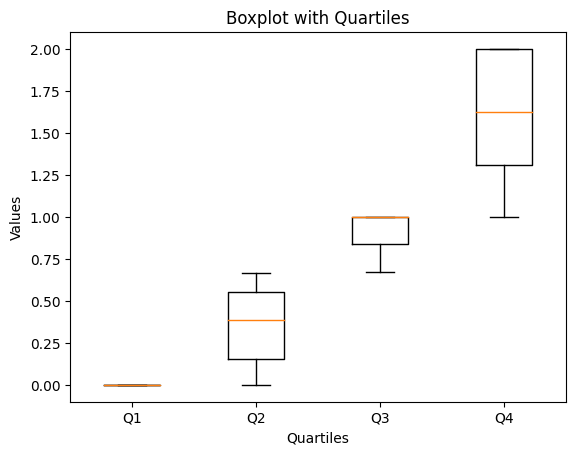


--------------------------------------

Histogramas para a coluna tempo_usando_eletronicos com log: False e bins: 100
tempo_usando_eletronicos <= 2.0


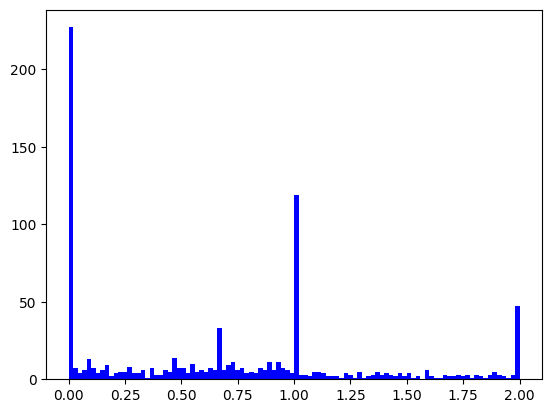


--------------------------------------

tempo_usando_eletronicos <= 1.0


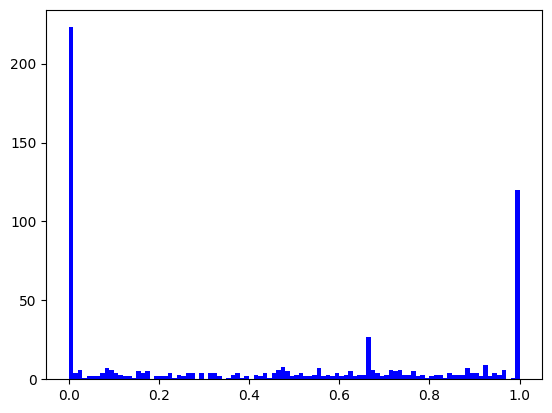


--------------------------------------

tempo_usando_eletronicos <= 0.6674500542056074


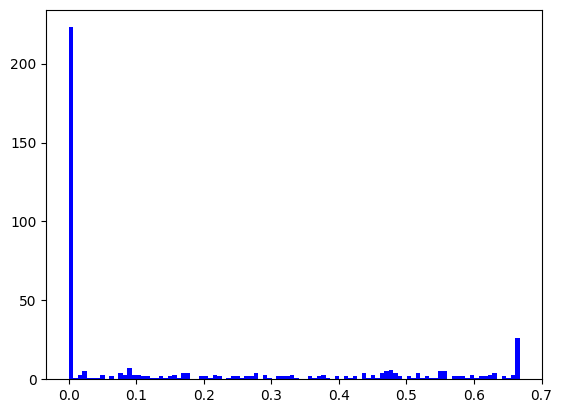


--------------------------------------

tempo_usando_eletronicos <= 0.0


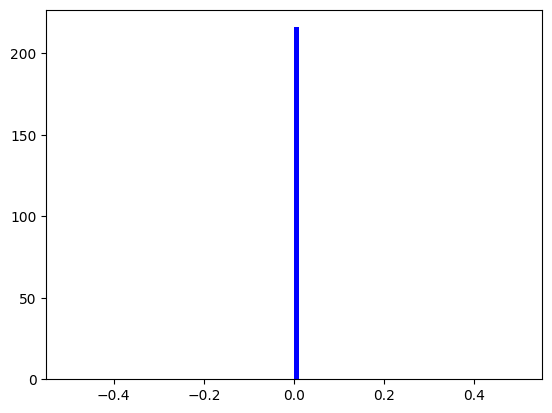


--------------------------------------


--------------------------------------

métricas gerais para tempo_usando_eletronicos_int
média: 0.690504103165299
mediana: 1.0
desvio padrão: 0.6750874428108485
kurtosis: -0.7946004134783613
skewness: 0.4649751630305509

--------------------------------------



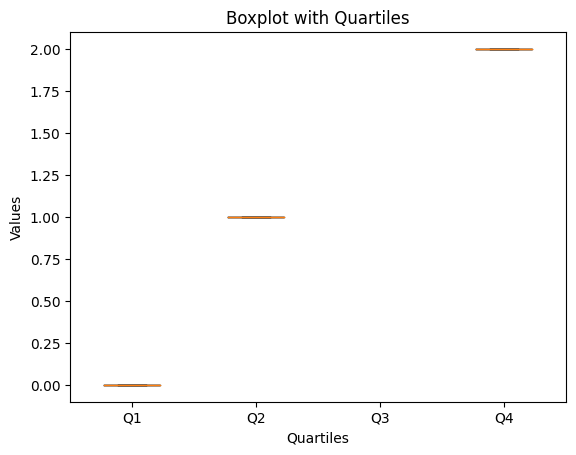


--------------------------------------

Histogramas para a coluna tempo_usando_eletronicos_int com log: False e bins: 100
tempo_usando_eletronicos_int <= 2.0


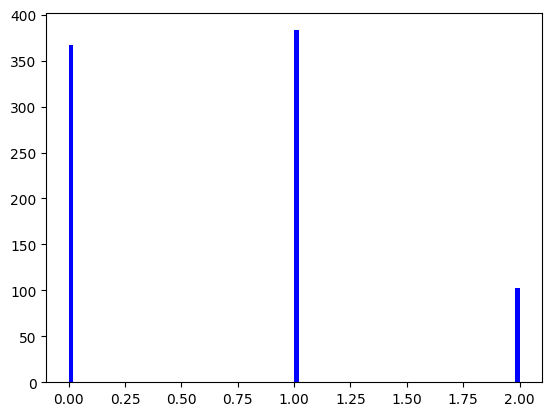


--------------------------------------

tempo_usando_eletronicos_int <= 1.0


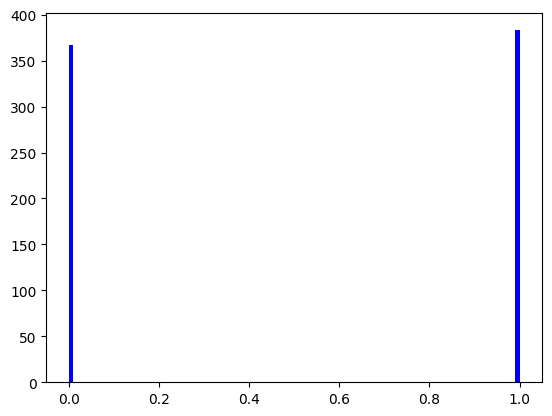


--------------------------------------

tempo_usando_eletronicos_int <= 1.0


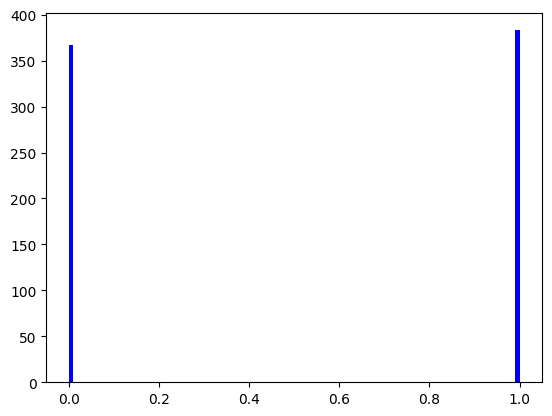


--------------------------------------

tempo_usando_eletronicos_int <= 0.0


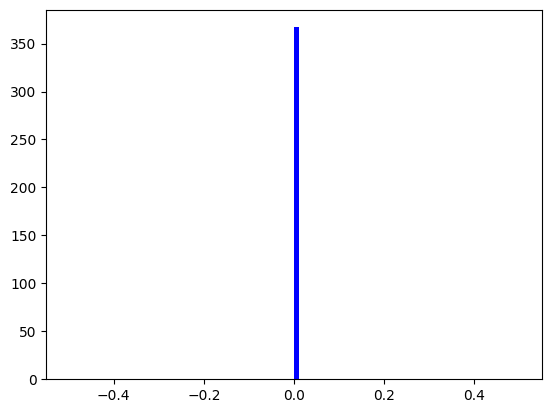


--------------------------------------


--------------------------------------

métricas gerais para IMG
média: 30.692886227606255
mediana: 29.863476173603576
desvio padrão: 11.686869158683937
kurtosis: -0.6032632528632211
skewness: 0.26556573674774464

--------------------------------------



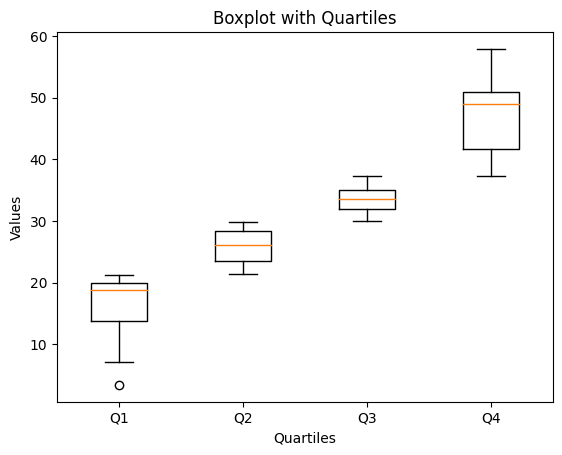


--------------------------------------

Histogramas para a coluna IMG com log: False e bins: 100
IMG <= 57.9235014026471


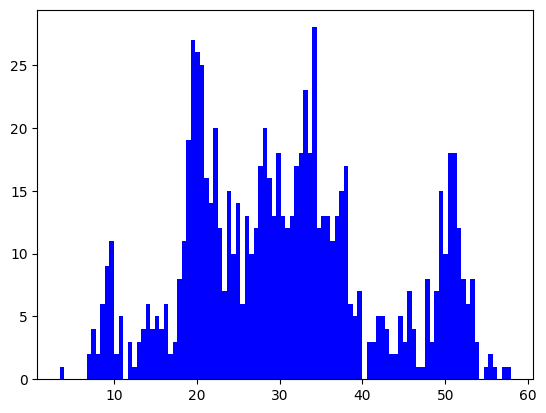


--------------------------------------

IMG <= 37.24776754907593


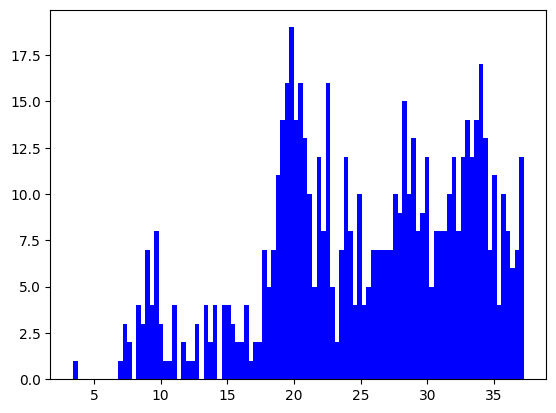


--------------------------------------

IMG <= 29.863476173603576


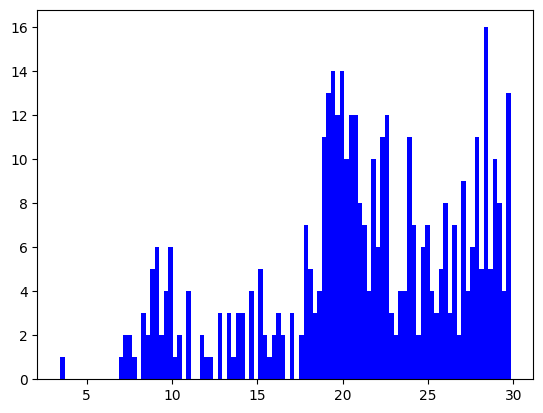


--------------------------------------

IMG <= 21.290673862812927


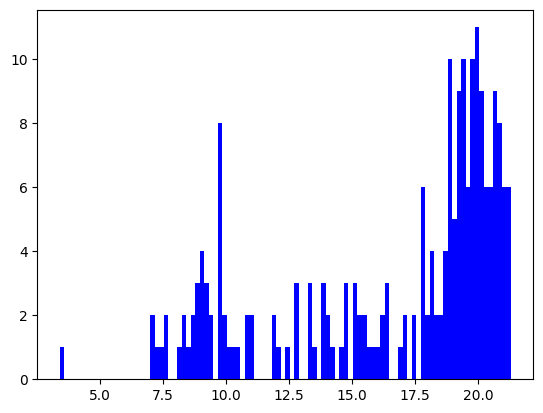


--------------------------------------


--------------------------------------

métricas gerais para IMC
média: 30.18860787556968
mediana: 29.642685467072578
desvio padrão: 7.966875341690571
kurtosis: -0.8306458793331015
skewness: 0.034883542589662454

--------------------------------------



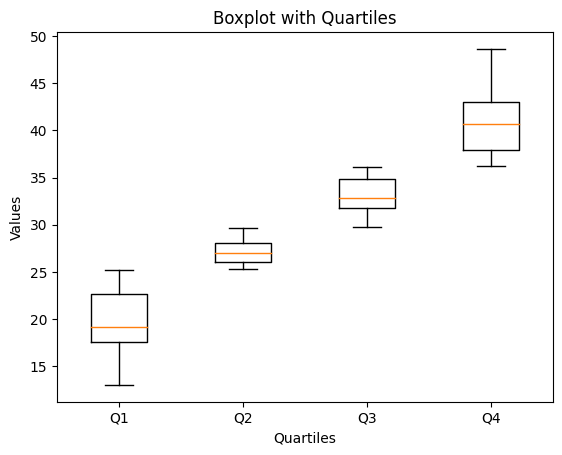


--------------------------------------

Histogramas para a coluna IMC com log: False e bins: 100
IMC <= 48.65169258051864


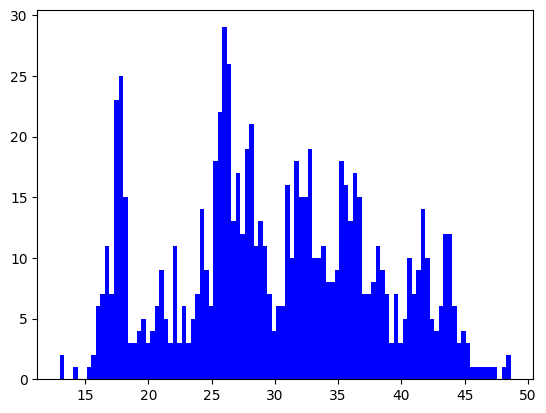


--------------------------------------

IMC <= 36.14413448216006


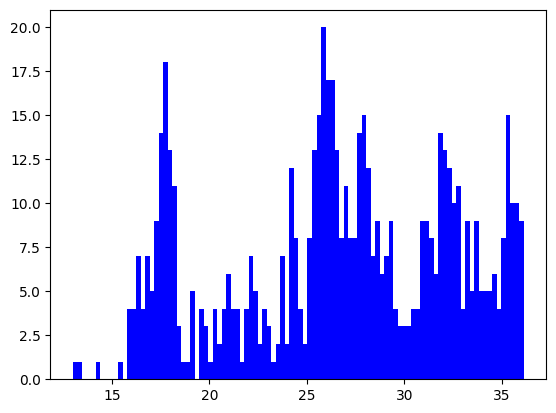


--------------------------------------

IMC <= 29.642685467072578


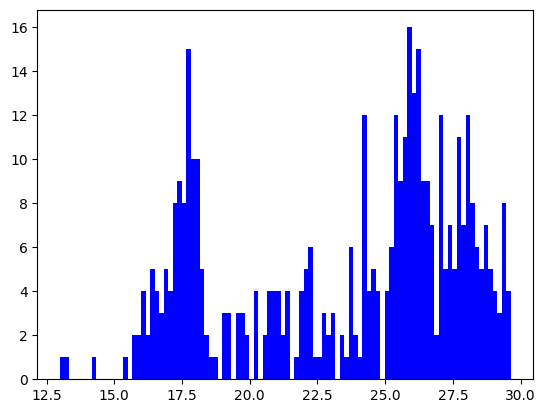


--------------------------------------

IMC <= 25.236340330075304


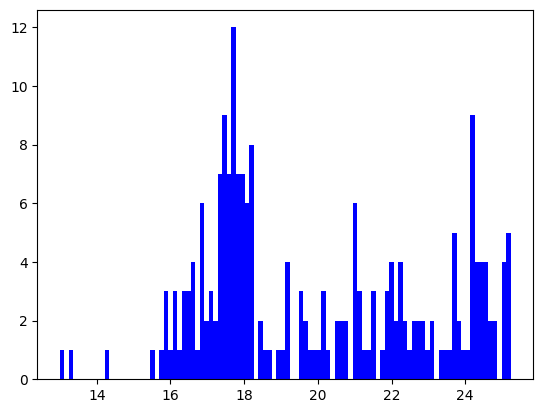


--------------------------------------



In [32]:
for row in numerical_columns:
  analyze_numerical_column(df[row]) 

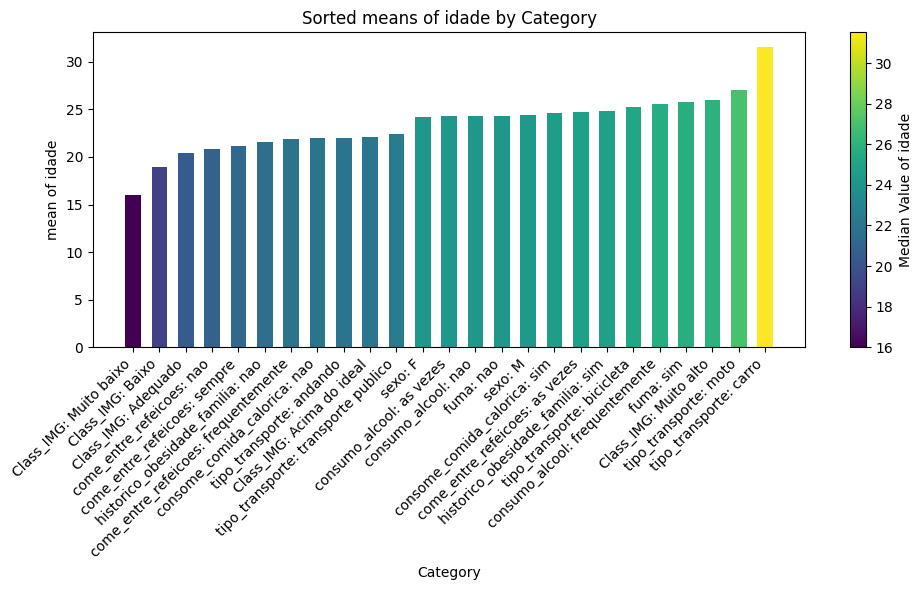

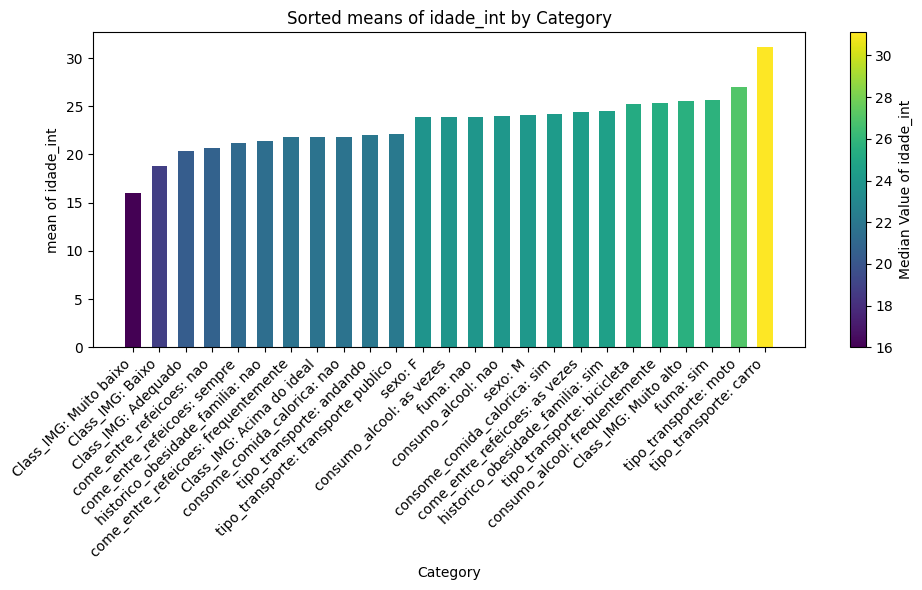

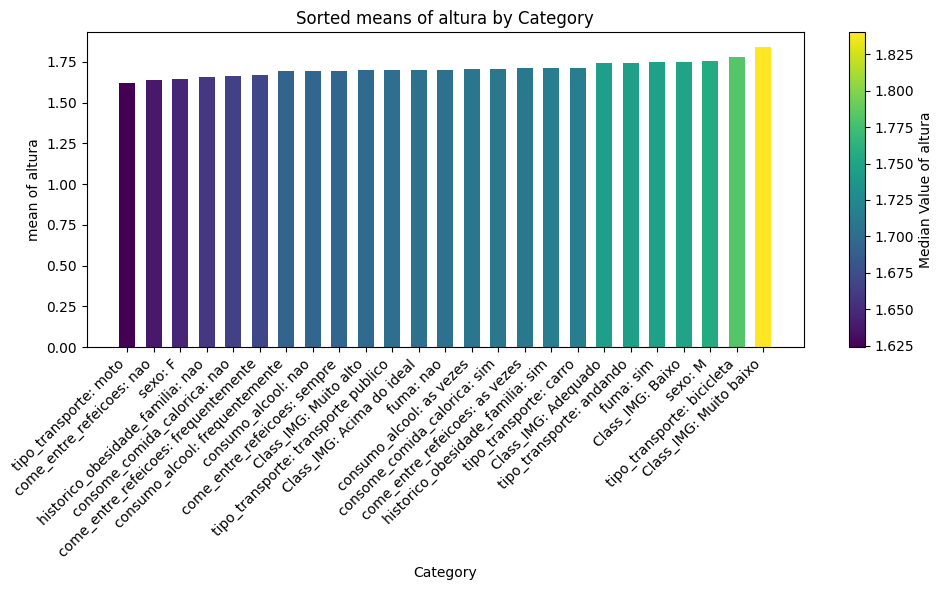

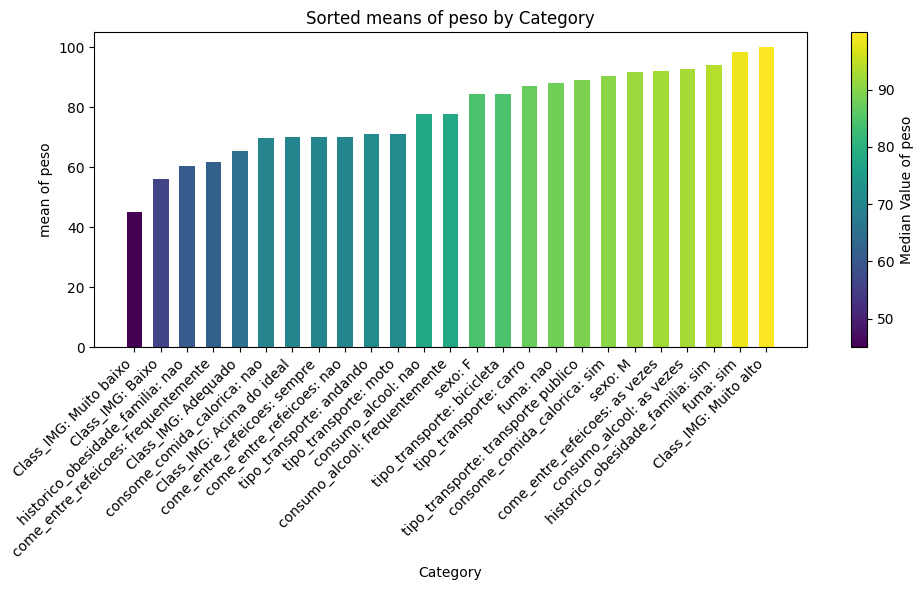

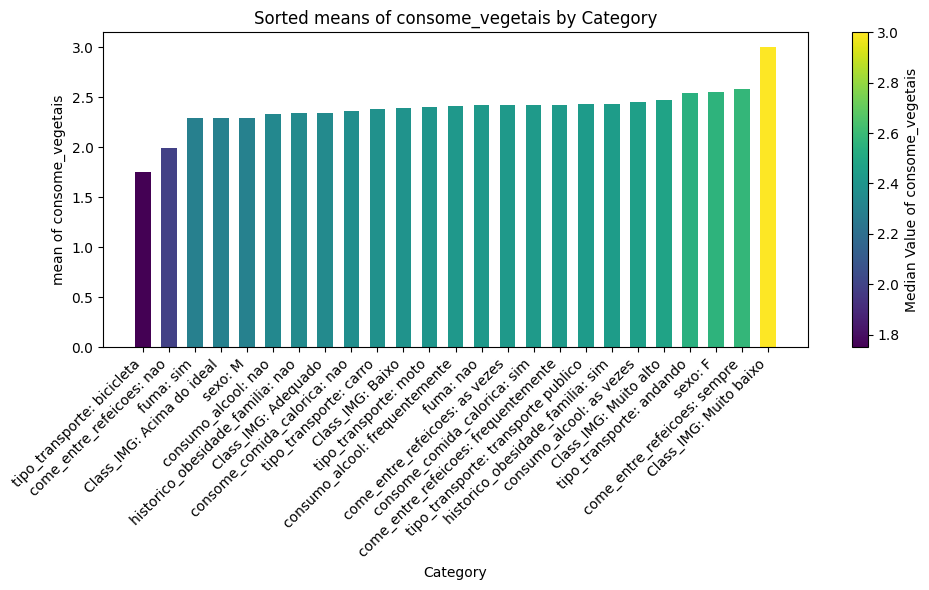

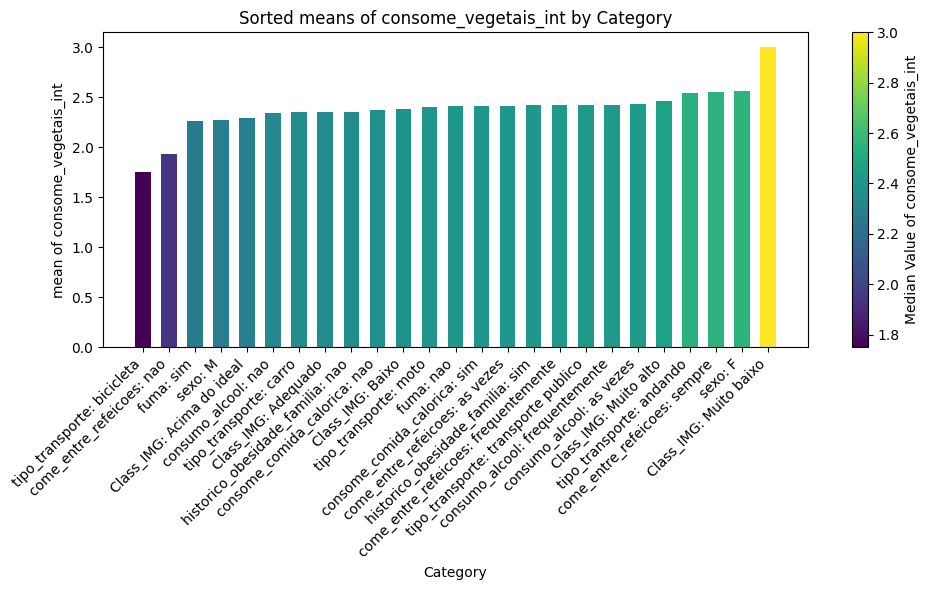

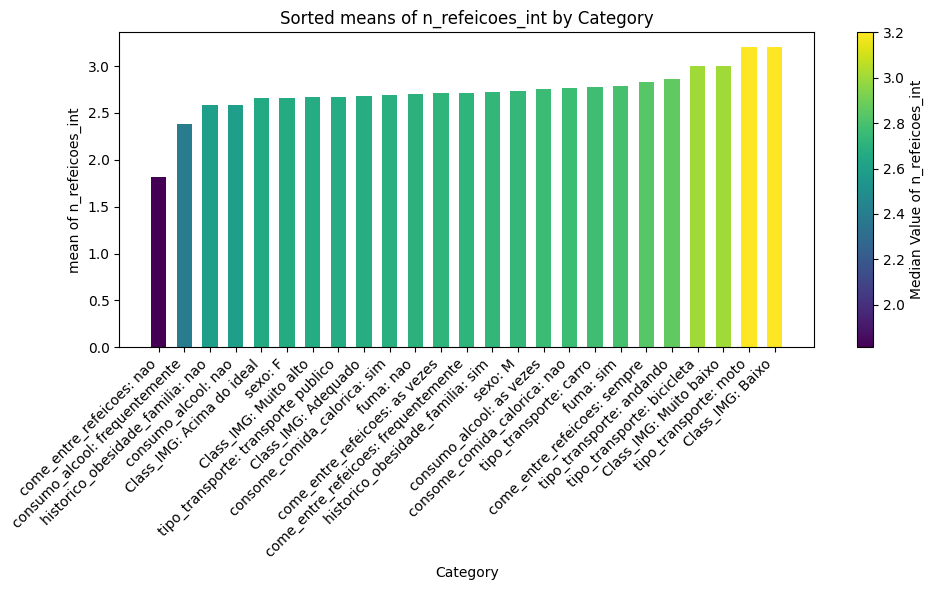

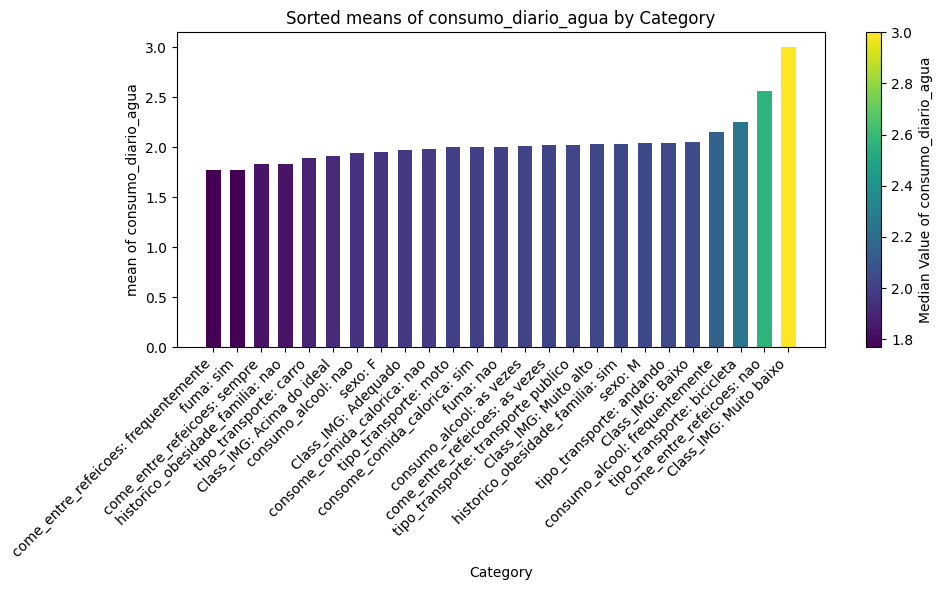

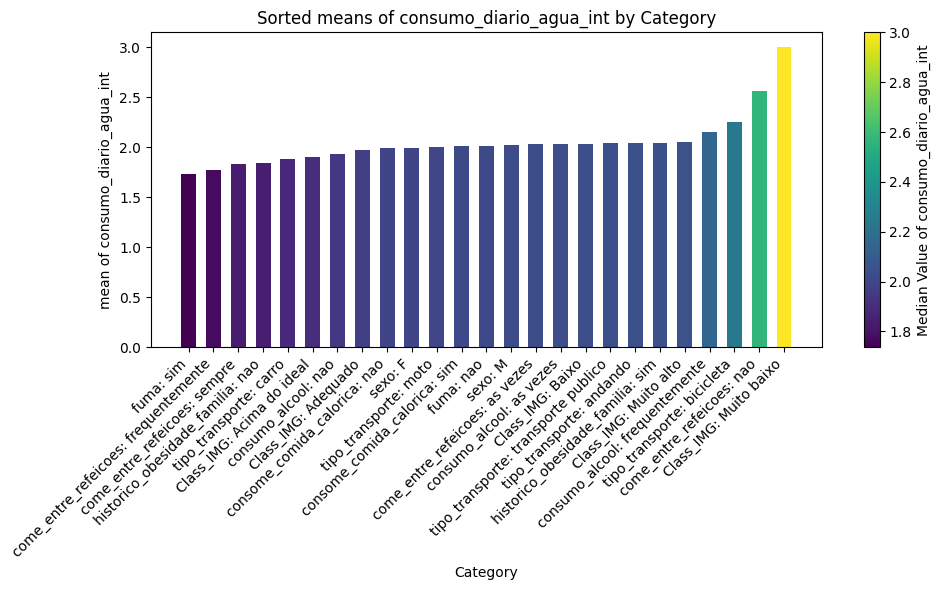

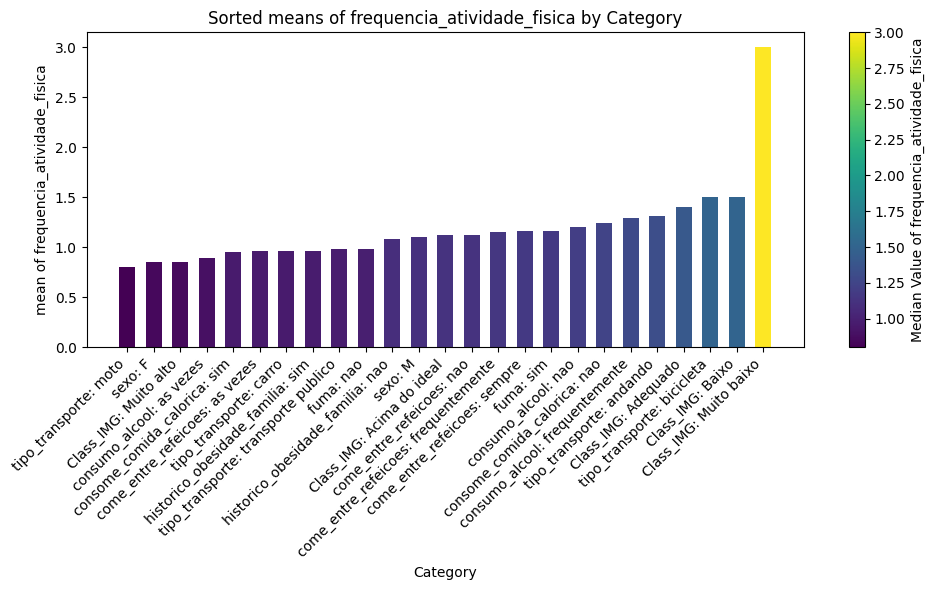

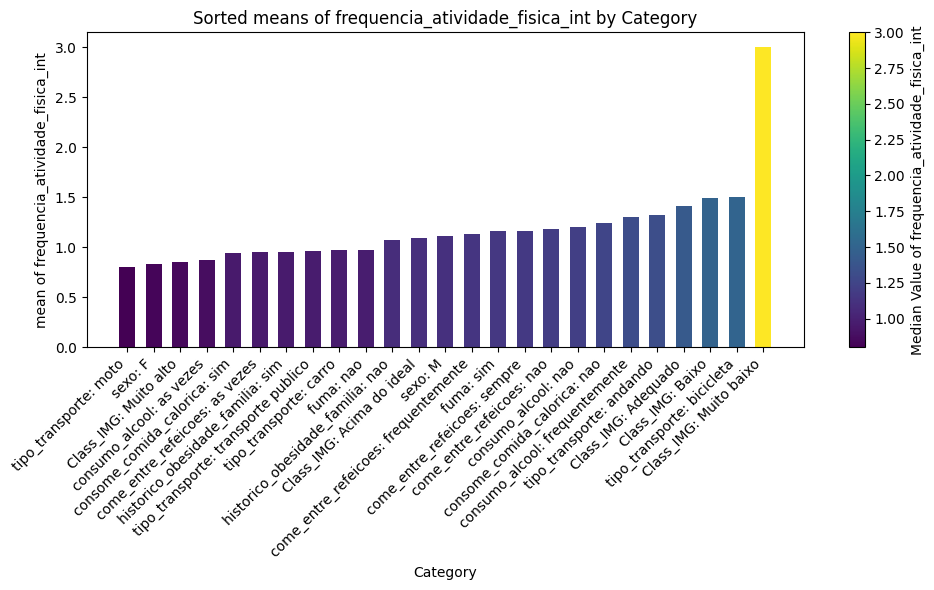

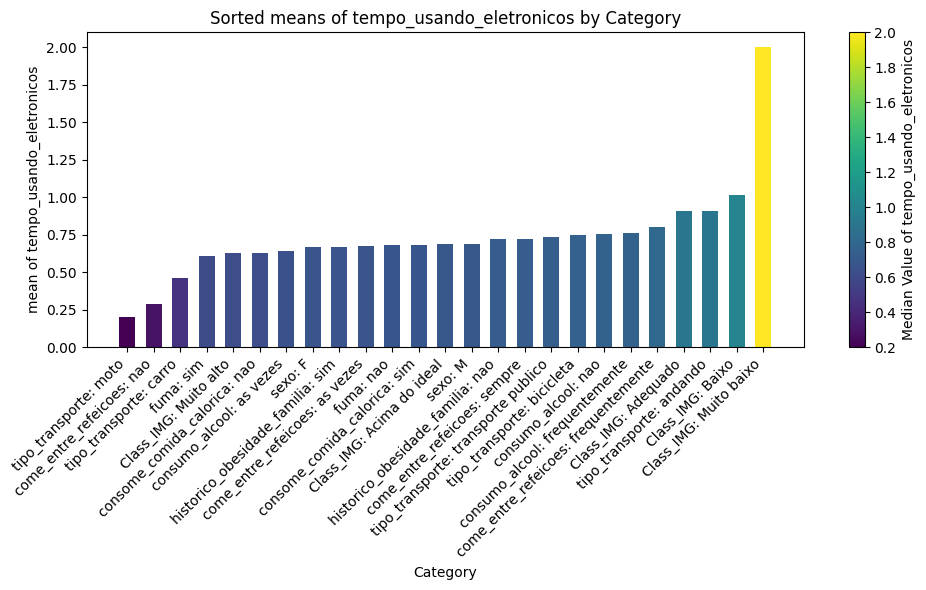

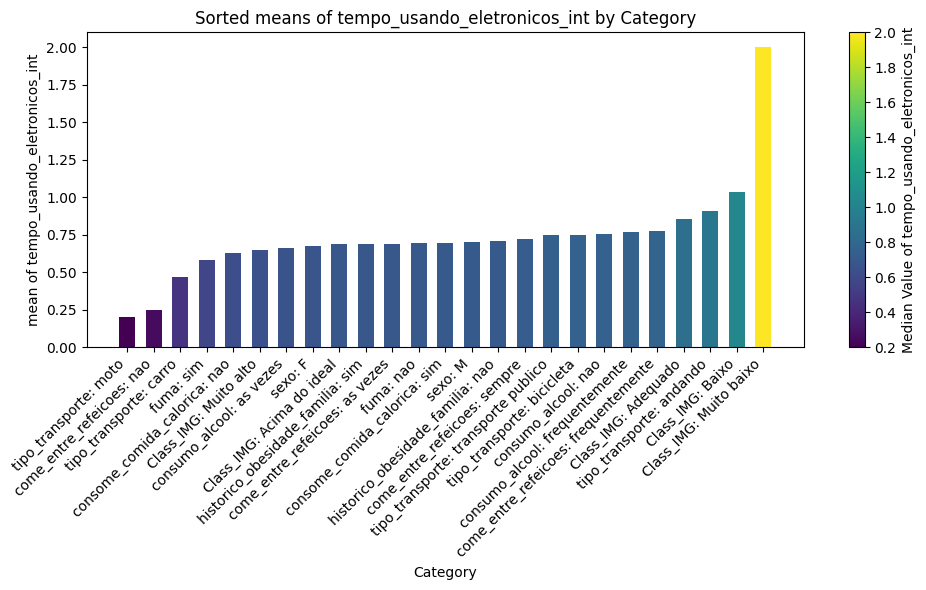

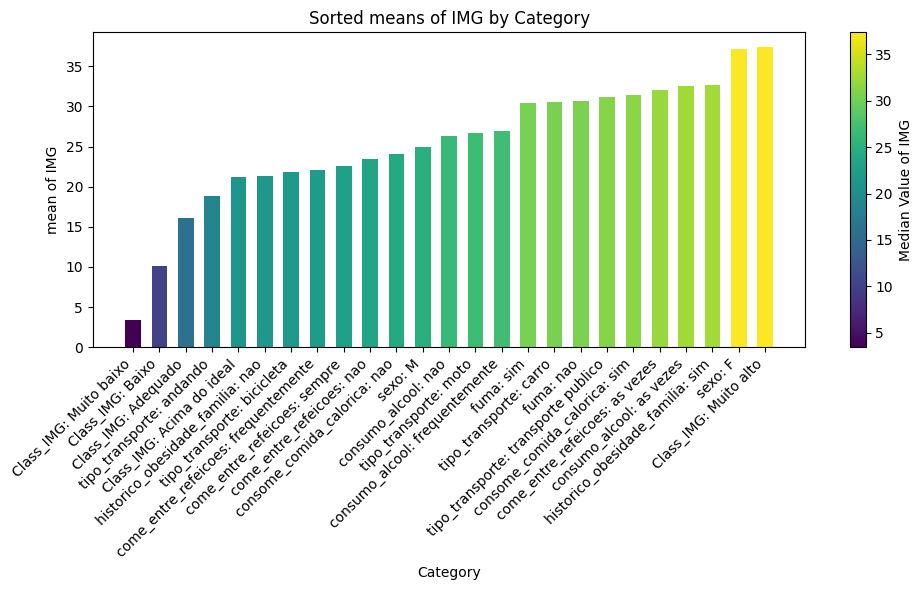

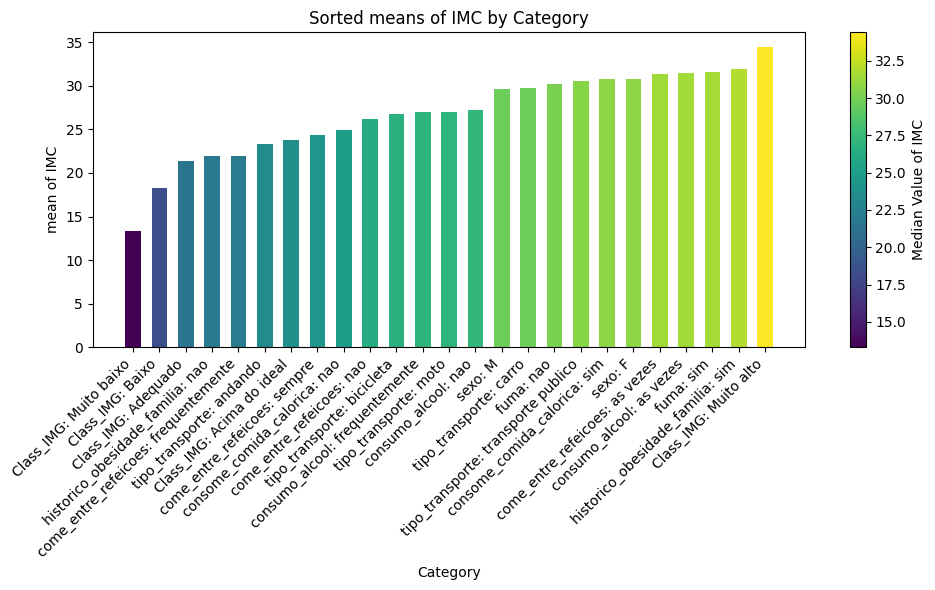

In [33]:
result_df = calculate_group_metric(df, category_columns, numerical_columns, metric='mean')
plot_sorted_group_metric(result_df, numerical_columns, metric='mean')


Correlação de Spearman entre consome_vegetais e IMG:
Coeficiente de correlação: 0.3253
Valor-p: 0.0000


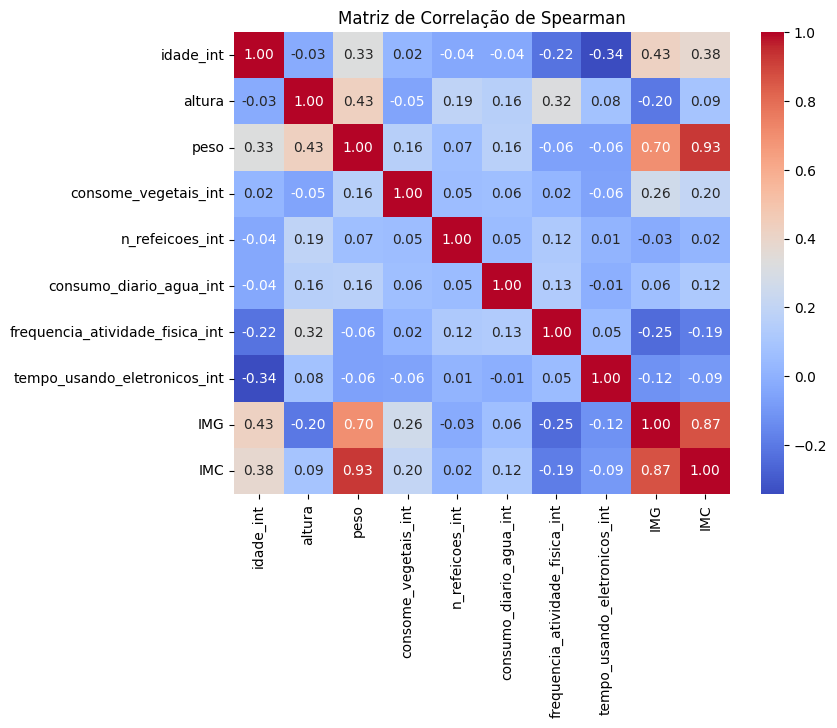

In [37]:
numeric_columns = ['idade_int', 'altura', 'peso', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua_int', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos_int', 'IMG', 'IMC']

# Filtrar apenas colunas numéricas
df_numeric = df[numeric_columns]

# Matriz de correlação de Spearman
correlation_matrix = df_numeric.corr(method='spearman')

# Calcular correlação entre duas variáveis específicas
var1 = 'consome_vegetais'
var2 = 'IMG'
corr, p_value = spearmanr(df[var1], df[var2])
print(f"\nCorrelação de Spearman entre {var1} e {var2}:")
print(f"Coeficiente de correlação: {corr:.4f}")
print(f"Valor-p: {p_value:.4f}")

# Mapa de calor da matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação de Spearman')
plt.show()